<div style="text-align: center;">
    <img src="https://www.igismap.com/wp-content/uploads/2016/06/airport_traffic_network.png" width="600" />
</div>

# 1) Flight Network Analysis  


---

To get starded we want to download the dateset and convert the table into the graph we will need to use for our analysis.

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#let's upload the dataset
df=pd.read_csv('/Users/jacopocaldana/Desktop/Università/ADM/HW5_ADM/Airports2.csv')



In [ ]:
#check for missing data
print(df.isnull().sum())

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64


Only some coordinates are missing, which is quite good for our analysis

In [ ]:
def table_to_graph(df, directed=True, edge_attr=None):
    # Create a directed or undirected graph
    G = nx.DiGraph() if directed else nx.Graph()

    # Add edges and attributes
    for _, row in df.iterrows():
        source = row['Origin_airport']
        destination = row['Destination_airport']

        # Include edge attributes if specified
        attributes = {attr: row[attr] for attr in edge_attr} if edge_attr else {}
        G.add_edge(source, destination, **attributes)

    return G

In [ ]:
# Convert the table to a directed graph with the distance between airports as an edge attribute (this can be changed according to our needs)
flight_graph = table_to_graph(df, directed=True, edge_attr=['Distance'])

# Print graph info
print(f"Number of nodes: {nx.number_of_nodes(flight_graph)}")
print(f"Number of edges: {nx.number_of_edges(flight_graph)}")

Number of nodes: 727
Number of edges: 36719


We now try to visualize this graph, knowing that can look messy considering the large number of nodes and edges.

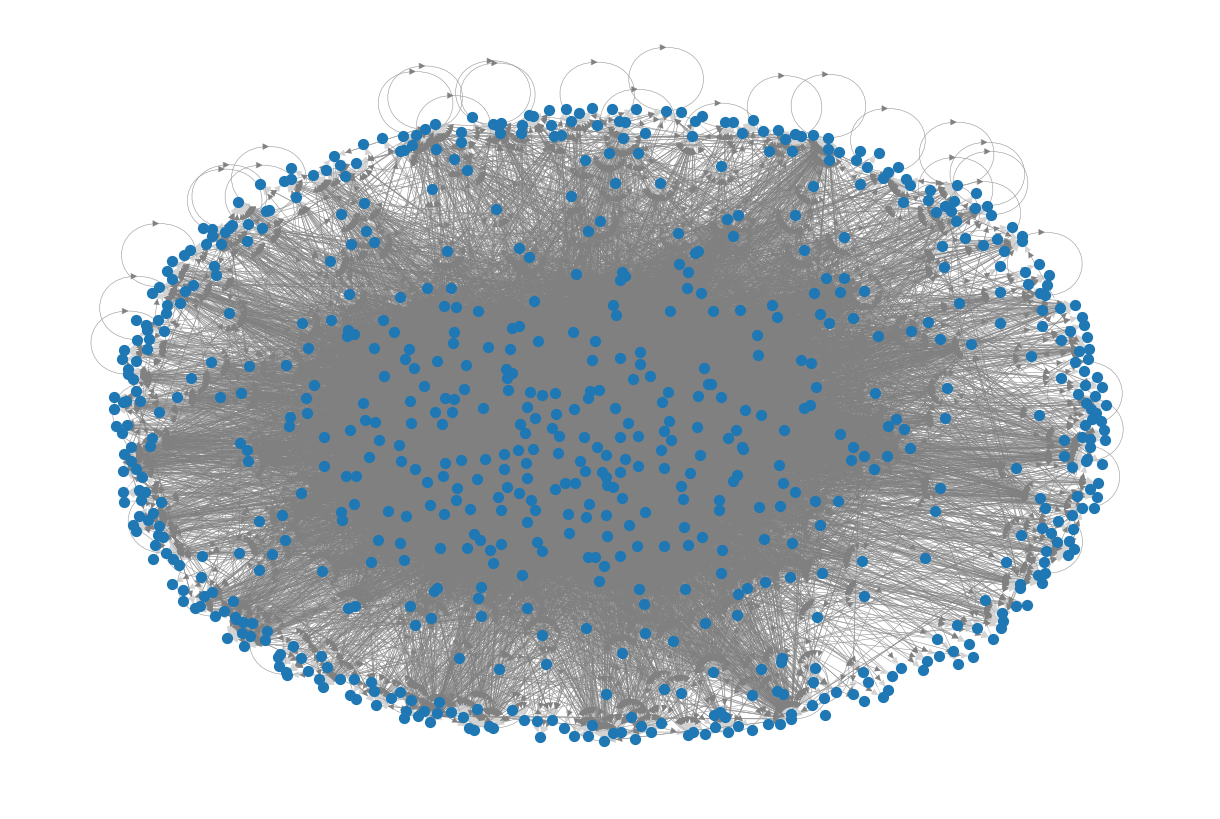

In [ ]:
# Create a copy of the graph so we do not modify the original df
flight_graph_copy = flight_graph.copy()

# Invert the distance on the copy
for u, v, data in flight_graph_copy.edges(data=True):
    data['InvertedDistance'] = 1 / data['Distance'] if data['Distance'] > 0 else 1

# Use Fruchterman-Reingold layout with the inverted distance
pos = nx.spring_layout(flight_graph_copy, k=0.3, iterations=100, weight='InvertedDistance')

# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(flight_graph_copy, pos, with_labels=False, node_size=50, edge_color='lightgray', width=0.5)
nx.draw_networkx_edges(flight_graph_copy, pos, edge_color='gray', width=0.2)
plt.show()

We used **Fruchterman-Reingold Algorithm** to visualize this graph, let's explain briefly how it positions the nodes in the graph:<br>
-Nodes repel each other, simulating a physical system where nodes act as charged particles.<br>
-Edges act like springs, pulling connected nodes closer together, with tension proportional to the edge weight.<br>
-Weight='InvertedDistance': Specifies that the spring forces should be scaled by the 'InvertedDistance' attribute of edges. This helps distant airports (large distances between them) be positioned farther apart.

---

## Analyze Graph Features

In [ ]:
def analyze_graph_features(flight_network):
    # 1. Count the number of airports (nodes) and flights (edges)
    num_nodes = flight_network.number_of_nodes()
    num_edges = flight_network.number_of_edges()

    # 2. Compute the density of the graph
    density = (num_edges) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0

    # 3. Compute in-degree and out-degree for each airport
    in_degrees = [d for _, d in flight_network.in_degree()]
    out_degrees = [d for _, d in flight_network.out_degree()]

    # Visualize in-degree and out-degree distributions
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(in_degrees, bins=30, color='skyblue', edgecolor='black')
    plt.title("In-Degree Distribution")
    plt.xlabel("In-Degree")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(out_degrees, bins=30, color='orange', edgecolor='black')
    plt.title("Out-Degree Distribution")
    plt.xlabel("Out-Degree")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    # 4. Identify hubs (airports with degrees higher than the 90th percentile)
    all_degrees = np.array(in_degrees) + np.array(out_degrees)
    threshold = np.percentile(all_degrees, 90)
    hubs = [(node,degree) for node, degree in flight_network.degree() if degree > threshold]
    hub_airports = [airport for airport, _ in hubs]

    # 5. Determine if the graph is sparse or dense
    is_sparse = density < 0.1  # Arbitrary threshold for sparsity
    sparsity_status = "sparse" if is_sparse else "dense"

    # Print the results
    print("Number of Airports (Nodes):", num_nodes)
    print("Number of Flights (Edges):", num_edges)
    print("Graph Density:", density)
    print(f"The graph is {sparsity_status}.")
    print("Airports identified as hubs:", hub_airports)

    # Create a DataFrame to display the hubs
    hubs_df = pd.DataFrame(hubs, columns=['Hub', 'Degree'])

    # Create a lookup dictionary for airport-to-city mapping
    airport_to_city = df.set_index('Origin_airport')['Origin_city'].to_dict()

    # Map the city names to the 'Hub' column in hubs_df
    hubs_df['City'] = hubs_df['Hub'].map(airport_to_city)

    # Sort the DataFrame by degree (descending order) for better readability
    hubs_df = hubs_df.sort_values(by='Degree', ascending=False)

    # Display the table
    print(hubs_df)




Since we are using a directed graph, we adapted the definition of density to our case. Anyway it is not necessary to approach the analysis with a directed graph.

We present also manual_in_out_degrees function implemented even though we are using the bult-in functions

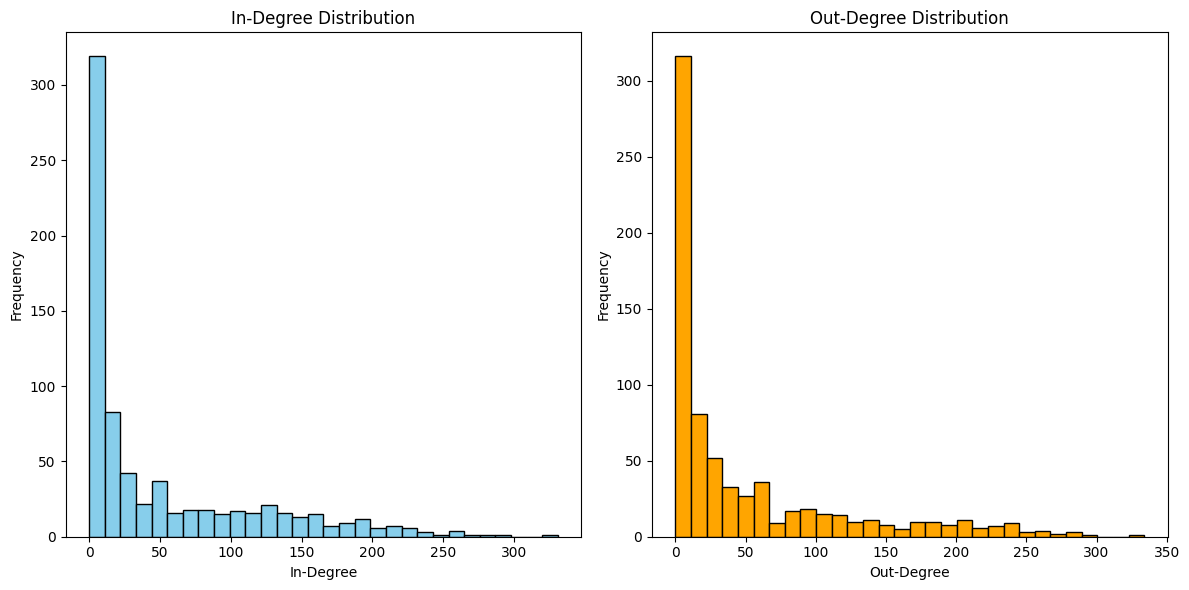

Number of Airports (Nodes): 727
Number of Flights (Edges): 36719
Graph Density: 0.0695696492245198
The graph is sparse.
Airports identified as hubs: ['SEA', 'PDX', 'SFO', 'LAX', 'FLL', 'PHX', 'TUS', 'DFW', 'SLC', 'RNO', 'ABQ', 'LAS', 'ICT', 'OKC', 'SAN', 'OAK', 'IAH', 'ELP', 'TUL', 'OMA', 'AUS', 'COS', 'MSN', 'RFD', 'MKE', 'DSM', 'LIT', 'SHV', 'MCI', 'SAT', 'MSP', 'ORD', 'STL', 'BNA', 'MEM', 'IND', 'LRD', 'CLE', 'DTW', 'DAY', 'CVG', 'CMH', 'FWA', 'HOU', 'TOL', 'PIT', 'BOS', 'ATL', 'MDW', 'PHL', 'GSO', 'BUF', 'EWR', 'CLT', 'JFK', 'GRR', 'YIP', 'LGA', 'LEX', 'BHM', 'MCO', 'IAD', 'MSY', 'RDU', 'GSP', 'BDL', 'CAE', 'BWI', 'TYS', 'MIA', 'TPA', 'DAL', 'JAX']
    Hub  Degree              City
56  YIP     665       Detroit, MI
30  MSP     583   Minneapolis, MN
34  MEM     564       Memphis, TN
47  ATL     539       Atlanta, GA
28  MCI     539   Kansas City, MO
..  ...     ...               ...
57  LGA     335      New York, NY
42  FWA     332    Fort Wayne, IN
55  GRR     327  Grand Rapids, MI

In [ ]:
analyze_graph_features(flight_graph)

Both graphs have a long tail, this shows that few airports have a high number of connections whereas most of the airports have few connections.<br>
This is a common fact in flight networks since bigger airports act as hub in order to concentrate the air traffic.<br>
The low density of the graph is a conseguence of this fact.

---

## Summarize Graph Features

In [ ]:
def summarize_graph_features(flight_network):
    # Create a lookup dictionary for airport-to-city mapping
    airport_to_city = df.set_index('Origin_airport')['Origin_city'].to_dict()

    # Number of nodes and edges
    num_nodes = nx.number_of_nodes(flight_network)
    num_edges = nx.number_of_edges(flight_network)

    # Graph density
    density = ( num_edges) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0

    # Degree distributions
    in_degrees = list(dict(flight_network.in_degree()).values())
    out_degrees = list(dict(flight_network.out_degree()).values())

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(in_degrees, bins=20)
    plt.title("In-Degree Distribution")
    plt.subplot(1, 2, 2)
    plt.hist(out_degrees, bins=20)
    plt.title("Out-Degree Distribution")
    plt.tight_layout()
    plt.show()

    # Identify hubs (we take only top5)
    hub_nodes = sorted(dict(flight_network.out_degree()).items(), key=lambda x: x[1], reverse=True)[:5]

    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Graph density: {density:.3f}")

    print("\nTop 5 hubs:")

    for node, degree in hub_nodes:
        # Get the city associated with the airport, defaulting to "Unknown" if not found
        city = airport_to_city.get(node, "Unknown")
        print(f"- Node {node} ({city}): {degree} outgoing edges")

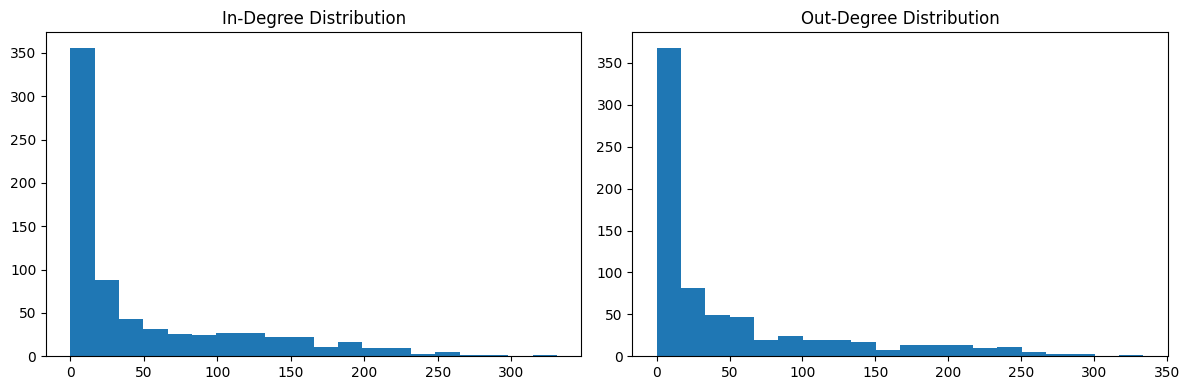

Number of nodes: 727
Number of edges: 36719
Graph density: 0.070

Top 5 hubs:
- Node YIP (Detroit, MI): 334 outgoing edges
- Node MSP (Minneapolis, MN): 292 outgoing edges
- Node MEM (Memphis, TN): 287 outgoing edges
- Node ORD (Chicago, IL): 286 outgoing edges
- Node ATL (Atlanta, GA): 280 outgoing edges


In [ ]:
summarize_graph_features(flight_graph)

---

## Deeper Analysis Of The Dataset

**Firstly we show the busiest routes in term of passengers traffic**

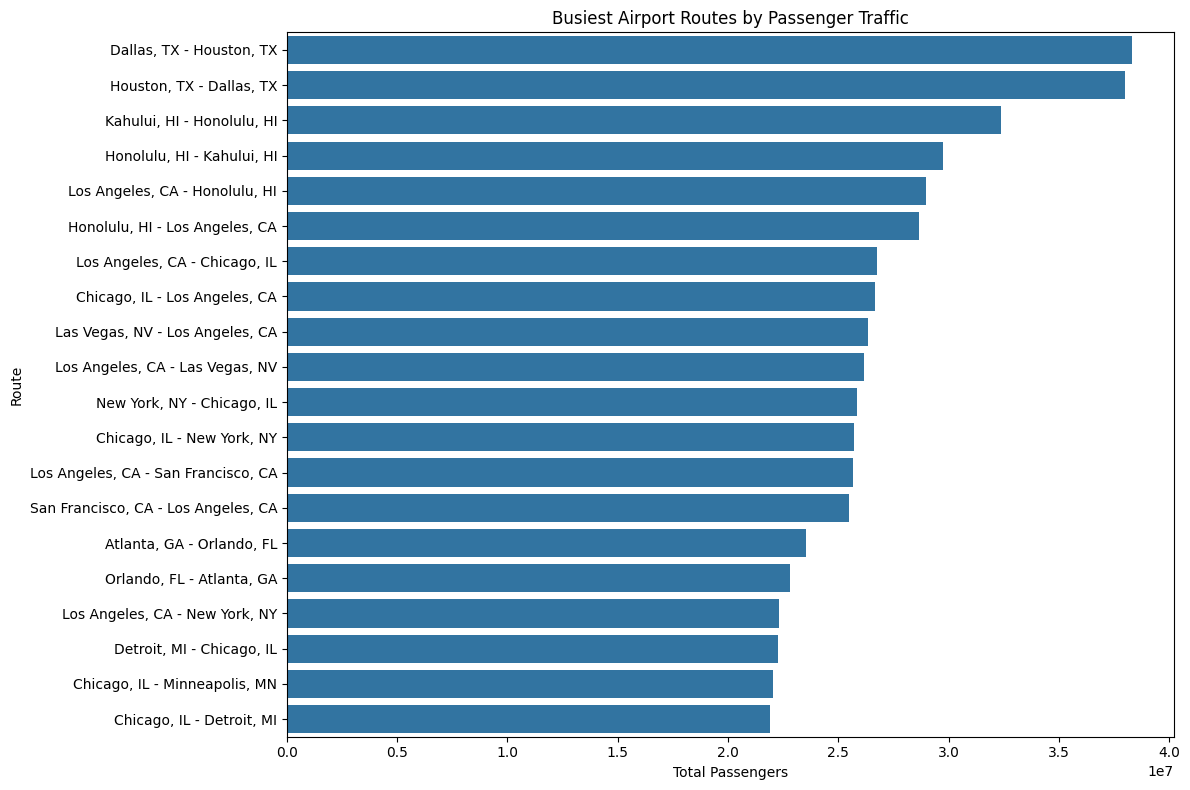

In [ ]:
# Calculate total passenger flow between city pairs
city_pairs = df[['Origin_city', 'Destination_city', 'Passengers']].groupby(['Origin_city', 'Destination_city']).sum().reset_index()
city_pairs = city_pairs.sort_values('Passengers', ascending=False)

# Create a new column with the combined city names
city_pairs['Route'] = city_pairs['Origin_city'] + ' - ' + city_pairs['Destination_city']

# Visualize the busiest routes
plt.figure(figsize=(12, 8))
sns.barplot(x='Passengers', y='Route', data=city_pairs[:20])
plt.title('Busiest Airport Routes by Passenger Traffic')
plt.xlabel('Total Passengers')
plt.ylabel('Route')
plt.tight_layout()

In [ ]:
city_pairs[:20]

Origin_city   Destination_city  Passengers  \
7122          Dallas, TX        Houston, TX    38295025   
12391        Houston, TX         Dallas, TX    37989016   
13585        Kahului, HI       Honolulu, HI    32364664   
12259       Honolulu, HI        Kahului, HI    29744742   
16133    Los Angeles, CA       Honolulu, HI    28964232   
12264       Honolulu, HI    Los Angeles, CA    28632161   
16083    Los Angeles, CA        Chicago, IL    26751937   
5323         Chicago, IL    Los Angeles, CA    26645096   
15218      Las Vegas, NV    Los Angeles, CA    26333721   
16152    Los Angeles, CA      Las Vegas, NV    26177809   
19394       New York, NY        Chicago, IL    25824282   
5355         Chicago, IL       New York, NY    25697559   
16218    Los Angeles, CA  San Francisco, CA    25661782   
24933  San Francisco, CA    Los Angeles, CA    25458207   
1511         Atlanta, GA        Orlando, FL    23531244   
20542        Orlando, FL        Atlanta, GA    22798949   
16180    Los Angeles, CA       New York, NY    22295397   
7790         Detroit, MI        Chicago, IL    22248863   
5338         Chicago, IL    Minneapolis, MN    22048061   
5248         Chicago, IL        Detroit, MI    21897735   

                                     Route  
7122              Dallas, TX - Houston, TX  
12391             Houston, TX - Dallas, TX  
13585           Kahului, HI - Honolulu, HI  
12259           Honolulu, HI - Kahului, HI  
16133       Los Angeles, CA - Honolulu, HI  
12264       Honolulu, HI - Los Angeles, CA  
16083        Los Angeles, CA - Chicago, IL  
5323         Chicago, IL - Los Angeles, CA  
15218      Las Vegas, NV - Los Angeles, CA  
16152      Los Angeles, CA - Las Vegas, NV  
19394           New York, NY - Chicago, IL  
5355            Chicago, IL - New York, NY  
16218  Los Angeles, CA - San Francisco, CA  
24933  San Francisco, CA - Los Angeles, CA  
1511             Atlanta, GA - Orlando, FL  
20542            Orlando, FL - Atlanta, GA  
16180       Los Angeles, CA - New York, NY  
7790             Detroit, MI - Chicago, IL  
5338         Chicago, IL - Minneapolis, MN  
5248             Chicago, IL - Detroit, MI

**Then we proceed by showing the most/least-utilized connections.**

In [ ]:
# Calculate average passengers per flight for each route
route_efficiency = df[['Origin_city', 'Destination_city', 'Passengers', 'Flights']].groupby(['Origin_city', 'Destination_city']).agg({'Passengers': 'sum', 'Flights': 'sum'}).reset_index()
route_efficiency['Avg_Passengers_per_Flight'] = route_efficiency['Passengers'] / route_efficiency['Flights']

# Sort them in order to easily identify most/least efficient connections
route_efficiency = route_efficiency.sort_values('Avg_Passengers_per_Flight')



---


### Let's clean the data

In [ ]:

# Drop rows with missing values
route_efficiency = route_efficiency.dropna()

# Or fill missing values
route_efficiency = route_efficiency.fillna(0)

route_efficiency = route_efficiency.astype({'Passengers': 'int', 'Flights': 'int'})

route_efficiency = route_efficiency[(route_efficiency['Passengers'] > 0) & (route_efficiency['Flights'] > 0)]

---

In [ ]:
#top 10 most efficient
route_efficiency.head(10)

Origin_city  Destination_city  Passengers  Flights  \
28859       Visalia, CA       Oakland, CA           7     3441   
23571  Rock Springs, WY        Casper, WY           6     2216   
334          Albany, NY       Memphis, TN           5     1767   
20885   Parkersburg, WV      Columbus, OH           2      402   
4166         Casper, WY   Scottsbluff, NE          10     2004   
23247      Riverton, WY        Casper, WY           9     1512   
23604      Rockford, IL        Boston, MA           2      299   
12102          Hays, KS       Wichita, KS           2      271   
4162         Casper, WY  Rock Springs, WY          28     3765   
16678    Manchester, NH       Memphis, TN          31     4076   

       Avg_Passengers_per_Flight  
28859                   0.002034  
23571                   0.002708  
334                     0.002830  
20885                   0.004975  
4166                    0.004990  
23247                   0.005952  
23604                   0.006689  
12102                   0.007380  
4162                    0.007437  
16678                   0.007605

In [ ]:
#top 10 least utilized
route_efficiency.tail(10)

Origin_city Destination_city  Passengers  Flights  \
12279    Honolulu, HI        Omaha, NE        1063        3   
14288   Knoxville, TN       Fresno, CA         355        1   
29084  Washington, DC     Honolulu, HI         362        1   
12225    Honolulu, HI     Billings, MT         377        1   
17005     Medford, OR       Topeka, KS         378        1   
26996   St. Louis, MO   Moses Lake, WA         380        1   
12281    Honolulu, HI      Oshkosh, WI         395        1   
23844     Roswell, NM     New York, NY         421        1   
12284    Honolulu, HI   Pittsburgh, PA         426        1   
21693  Pittsburgh, PA     Honolulu, HI         426        1   

       Avg_Passengers_per_Flight  
12279                 354.333333  
14288                 355.000000  
29084                 362.000000  
12225                 377.000000  
17005                 378.000000  
26996                 380.000000  
12281                 395.000000  
23844                 421.000000  
12284                 426.000000  
21693                 426.000000

**Attention:** Most of the above connections have only 1 flight, this data has a big influence on the analysis since it conveys only information about a specific flight and not a route.

In [ ]:
# Identify most efficient connections with more than 10 flights
most_efficient = route_efficiency[(route_efficiency['Flights'] > 10)].tail(10)
most_efficient

Origin_city Destination_city  Passengers  Flights  \
12222        Honolulu, HI      Atlanta, GA     1727637     6979   
24300  Salt Lake City, UT     Honolulu, HI      766018     3055   
12260        Honolulu, HI  Kansas City, MO        3561       14   
2317           Bangor, ME      Orlando, FL     1115347     4371   
12301        Honolulu, HI    St. Louis, MO     1202557     4635   
17956     Minneapolis, MN     Honolulu, HI     1359279     5239   
26944       St. Louis, MO     Honolulu, HI     1142259     4390   
12270        Honolulu, HI  Minneapolis, MN     1365628     5235   
16062     Los Angeles, CA       Bangor, ME       25737       91   
2294           Bangor, ME  Los Angeles, CA       26600       80   

       Avg_Passengers_per_Flight  
12222                 247.547930  
24300                 250.742390  
12260                 254.357143  
2317                  255.169755  
12301                 259.451348  
17956                 259.453903  
26944                 260.195672  
12270                 260.864947  
16062                 282.824176  
2294                  332.500000

This second table gives a more truthful information about the most over utilized routes.

In [ ]:
#This will help us for the visualization:
#I create a new coloumn with the route so when I plot it easier to understand.
route_efficiency['Route'] = route_efficiency['Origin_city'] + ' - ' + route_efficiency['Destination_city']
most_efficient['Route'] = most_efficient['Origin_city'] + ' - ' + most_efficient['Destination_city']

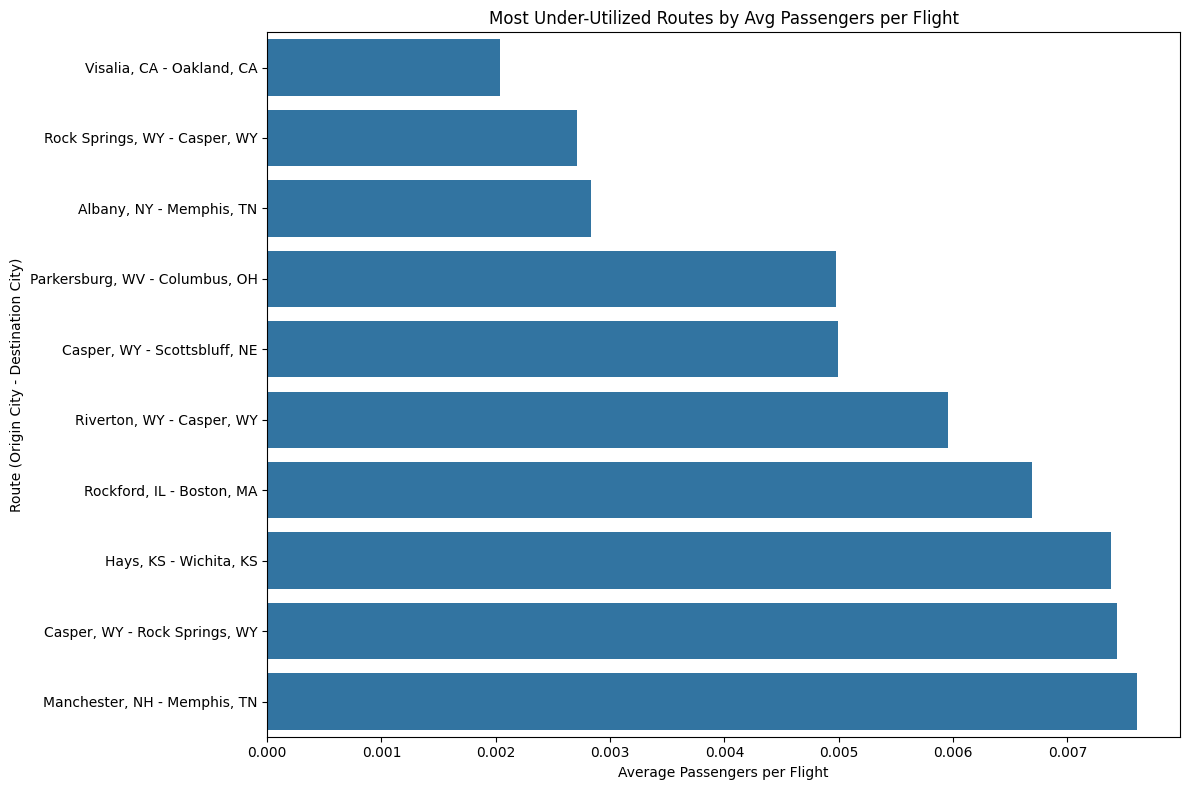

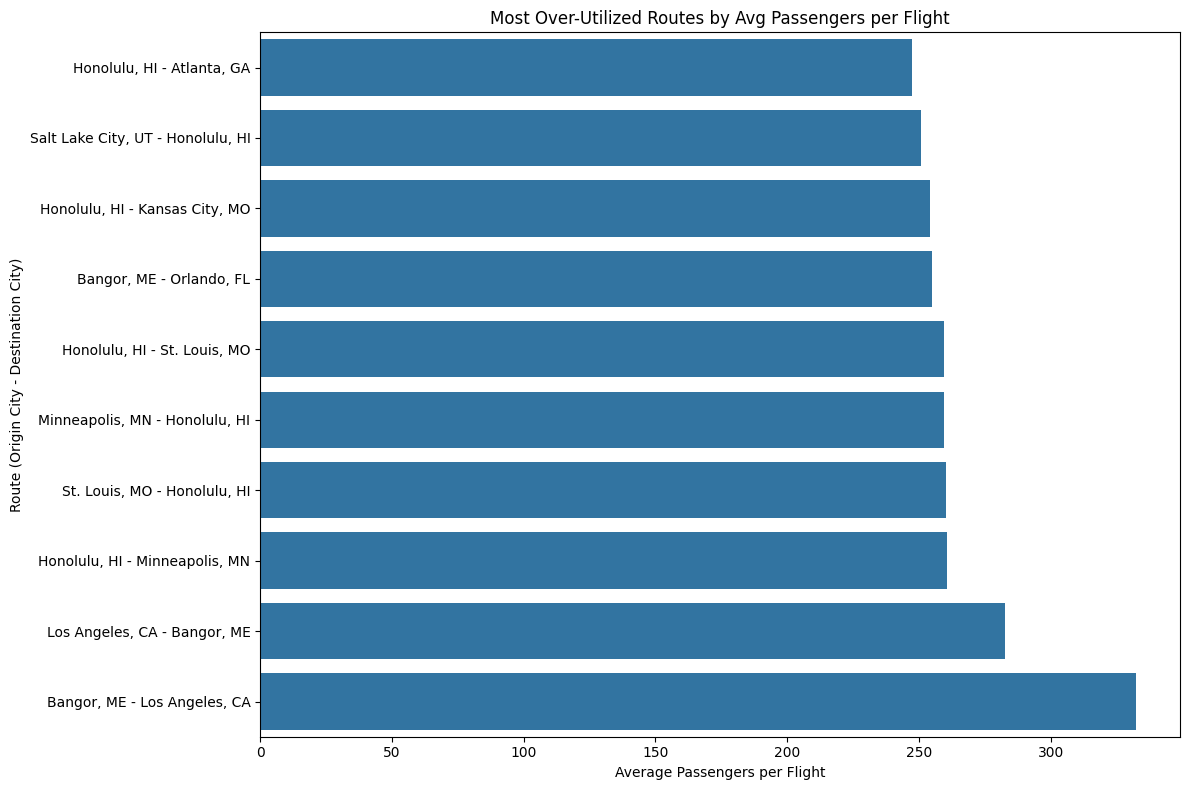

In [ ]:

# Top 10 most under-utilized routes (lowest Avg_Passengers_per_Flight)
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Avg_Passengers_per_Flight',
    y='Route',
    data=route_efficiency.head(10)
)
plt.title('Most Under-Utilized Routes by Avg Passengers per Flight')
plt.xlabel('Average Passengers per Flight')
plt.ylabel('Route (Origin City - Destination City)')
plt.tight_layout()
plt.show()

# Top 10 most over-utilized routes (highest Avg_Passengers_per_Flight)
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Avg_Passengers_per_Flight',
    y='Route' ,
    data=most_efficient
)
plt.title('Most Over-Utilized Routes by Avg Passengers per Flight')
plt.xlabel('Average Passengers per Flight')
plt.ylabel('Route (Origin City - Destination City)')
plt.tight_layout()
plt.show()

Here above we can see the **routes** with rispectively the lower and higher number of **average passengers per flight**.

---


Now let's analyze the **over/under utilized** routes.<br>
In order to do so we need to calculate the relationship between the passengers and the available seats for each route.

In [ ]:
route_stats = df[['Origin_city', 'Destination_city', 'Passengers', 'Seats', 'Flights']].groupby(['Origin_city', 'Destination_city']).agg({'Passengers': 'sum','Seats': 'sum', 'Flights':'sum'}).reset_index()

#Calculate Seat Utilization and store the value in a new column.
route_stats['Seat_Utilization'] = route_stats['Passengers'] / route_stats['Seats']
#Sort by Seat Utilization
route_stats=route_stats.sort_values(by='Seat_Utilization', ascending=False)


In [ ]:
#We clean the data just in case.
# Drop rows with missing values
route_stats = route_stats.dropna()

# Or fill missing values
route_stats = route_stats.fillna(0)

route_stats = route_stats.astype({'Passengers': 'int', 'Seats': 'int', 'Flights': 'int'})

route_stats = route_stats[(route_stats['Passengers'] > 0) & (route_stats['Seats'] > 0)]

In [ ]:
over_utilized_routes = route_stats.head(10)
print("Top 10 Over-Utilized Routes:")
over_utilized_routes


Top 10 Over-Utilized Routes:


Origin_city Destination_city  Passengers  Seats  Flights  \
22606      Raleigh, NC  Parkersburg, WV          60     59        1   
11730   Harrisburg, PA      Augusta, GA          50     50        1   
548    Albuquerque, NM  Springfield, IL         131    131        1   
8323    Eau Claire, WI      Abilene, TX         124    124        1   
29258     Waterloo, IA     Longview, TX          84     84        1   
18949    Nashville, TN         Erie, PA         100    100        1   
8855          Erie, PA     Scranton, PA          50     50        1   
29119   Washington, DC   Mason City, IA         486    486        3   
7157        Dallas, TX    Lynchburg, VA          50     50        1   
22496      Raleigh, NC    Brunswick, GA          50     50        1   

       Seat_Utilization  
22606          1.016949  
11730          1.000000  
548            1.000000  
8323           1.000000  
29258          1.000000  
18949          1.000000  
8855           1.000000  
29119          1.000000  
7157           1.000000  
22496          1.000000

9 out of 10 routes here have only had 1 flight, this analysis can be misleading, or better, it does not properly convey significant information about routes but more about those specific flights. In order for our reader to have also a more open prospective on over utilized routes we will present a second result considering only routes with more than 10 flights.<br>

For some reasons the flight from Raleigh,NC to Parkersburg, WV results having a passenger more than its seats. Since it is not disproportional we decided to include it because we feel it does not falsify our analysis.

In [ ]:
more_than_ten=route_stats[(route_stats['Flights'] >10)].head(10)
print("Top 10 Over-Utilized Routes with more than 10 Flights:")
more_than_ten

Top 10 Over-Utilized Routes with more than 10 Flights:


Origin_city Destination_city  Passengers  Seats  Flights  \
24083      Saginaw, MI   Shreveport, LA          56     56       39   
17192      Memphis, TN     Portland, ME          50     50     1837   
10088   Fort Wayne, IN  Los Angeles, CA         379    380     1421   
16117  Los Angeles, CA   Fort Wayne, IN         354    355     1729   
14947       Laredo, TX      Detroit, MI         224    225      940   
947      Anchorage, AK       Dayton, OH         181    183      142   
25783      Seattle, WA   Fort Wayne, IN         178    180      971   
17151      Memphis, TN   Manchester, NH         172    174     4095   
2151     Baltimore, MD        Ocala, FL         172    174       31   
10950  Great Falls, MT       Casper, WY         148    150       24   

       Seat_Utilization  
24083          1.000000  
17192          1.000000  
10088          0.997368  
16117          0.997183  
14947          0.995556  
947            0.989071  
25783          0.988889  
17151          0.988506  
2151           0.988506  
10950          0.986667

In [ ]:
under_utilized_routes = route_stats.tail(10)
print("\nTop 10 Under-Utilized Routes:")
under_utilized_routes


Top 10 Under-Utilized Routes:


Origin_city Destination_city  Passengers  Seats  Flights  \
17303    Merced, CA   Sacramento, CA           2    784       12   
23604  Rockford, IL       Boston, MA           2    840      299   
23274   Roanoke, VA      Buffalo, NY           1    486        5   
8221     Duluth, MN      Durango, CO          30  15100        1   
23681  Rockford, IL      Memphis, TN           1    516      106   
27458  Syracuse, NY   Youngstown, OH           1    608        5   
17456     Miami, FL    Lafayette, IN           2   1224        8   
17287    Merced, CA  Los Angeles, CA           1    625       12   
28925      Waco, TX     New York, NY           1    768        4   
5976     Clovis, NM        Hobbs, NM           7   6403      337   

       Seat_Utilization  
17303          0.002551  
23604          0.002381  
23274          0.002058  
8221           0.001987  
23681          0.001938  
27458          0.001645  
17456          0.001634  
17287          0.001600  
28925          0.001302  
5976           0.001093

Some of the results we get from the under-utilized routes do not look real.<br> Doing a small research here: https://www.travel365.it/classifica-aerei-piu-grandi-del-mondo.htm we found out that nowadays the biggest airliners can take up to 850 passengers, therefore the number of seats for the flight Duluth-->Durango is wrong.<br> Must be observed, moreover, that most of the routes were still active even though the number of passengers was incredibly scarse. Honestly we do not believe that companies would have allowed planes to fly empty. This is why this output does not give us a feeling of truth. Anyway this is what we got, a possible solution would be setting a threshold and only considering flights with at least a certain percentage of seat utilization.

---
# Interactive Map


In [ ]:
pip install folium

  Using cached xyzservices-2024.9.0-py3-none-any.whl.metadata (4.1 kB)
Using cached xyzservices-2024.9.0-py3-none-any.whl (85 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Need to clean the data
df = df.dropna(subset=['Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long'])
df['Org_airport_lat'].fillna(0, inplace=True)
df['Org_airport_long'].fillna(0, inplace=True)
df['Dest_airport_lat'].fillna(0, inplace=True)
df['Dest_airport_long'].fillna(0, inplace=True)

/var/folders/tx/0r7d70vd1r5fj6hhc8kdkh680000gn/T/ipykernel_28192/1899558232.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Org_airport_lat'].fillna(0, inplace=True)
/var/folders/tx/0r7d70vd1r5fj6hhc8kdkh680000gn/T/ipykernel_28192/1899558232.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [ ]:
import folium
import pandas as pd

def create_flight_network_map(df, map_center=[39.8283, -98.5795], zoom_start=4, output_file="flight_network_map.html", sample_size=100):
    """
    Creates a flight network map from a DataFrame containing airport information.

    Parameters:
        df (pd.DataFrame): DataFrame with the following columns:
            - 'Origin_airport', 'Org_airport_lat', 'Org_airport_long'
            - 'Destination_airport', 'Dest_airport_lat', 'Dest_airport_long'
        map_center (list): Latitude and longitude to center the map in the US.
        zoom_start (int): Initial zoom level of the map.
        output_file (str): File name to save the HTML map.
        sample_size (int): Number of rows to sample from the DataFrame.

    Returns:
        None. Saves the map to an HTML file.
    """
    # Sample the DataFrame
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        print(f"Sampled {sample_size} routes from the original DataFrame.")

    # Initialize the map
    flight_map = folium.Map(location=map_center, zoom_start=zoom_start)

    # Combine Origin and Destination airports into a single DataFrame
    airports = pd.concat([
        df[["Origin_airport", "Org_airport_lat", "Org_airport_long"]].rename(
            columns={"Origin_airport": "Airport", "Org_airport_lat": "Latitude", "Org_airport_long": "Longitude"}
        ),
        df[["Destination_airport", "Dest_airport_lat", "Dest_airport_long"]].rename(
            columns={"Destination_airport": "Airport", "Dest_airport_lat": "Latitude", "Dest_airport_long": "Longitude"}
        ),
    ])

    # Remove duplicates to avoid redundant markers
    unique_airports = airports.drop_duplicates(subset=["Airport", "Latitude", "Longitude"])

    # Add markers for each unique airport
    for _, row in unique_airports.iterrows():
        folium.Marker(
            location=(row["Latitude"], row["Longitude"]),
            popup=f"Airport: {row['Airport']}",
            icon=folium.Icon(color='blue', icon='plane')
        ).add_to(flight_map)

    # Add edges (routes) between Origin and Destination airports
    for _, row in df.iterrows():
        folium.PolyLine(
            locations=[
                (row["Org_airport_lat"], row["Org_airport_long"]),  # Origin coordinates
                (row["Dest_airport_lat"], row["Dest_airport_long"])  # Destination coordinates
            ],
            color="blue",
            weight=2,  # Line weight
            opacity=0.7,  # Line transparency
            tooltip=f"Route: {row['Origin_airport']} to {row['Destination_airport']}"
        ).add_to(flight_map)

    # Save the map to an HTML file
    flight_map.save(output_file)
    print(f"Map has been saved as {output_file}. Open this file in your browser to view it.")

In [ ]:
create_flight_network_map(df)

Sampled 100 routes from the original DataFrame.
Map has been saved as flight_network_map.html. Open this file in your browser to view it.


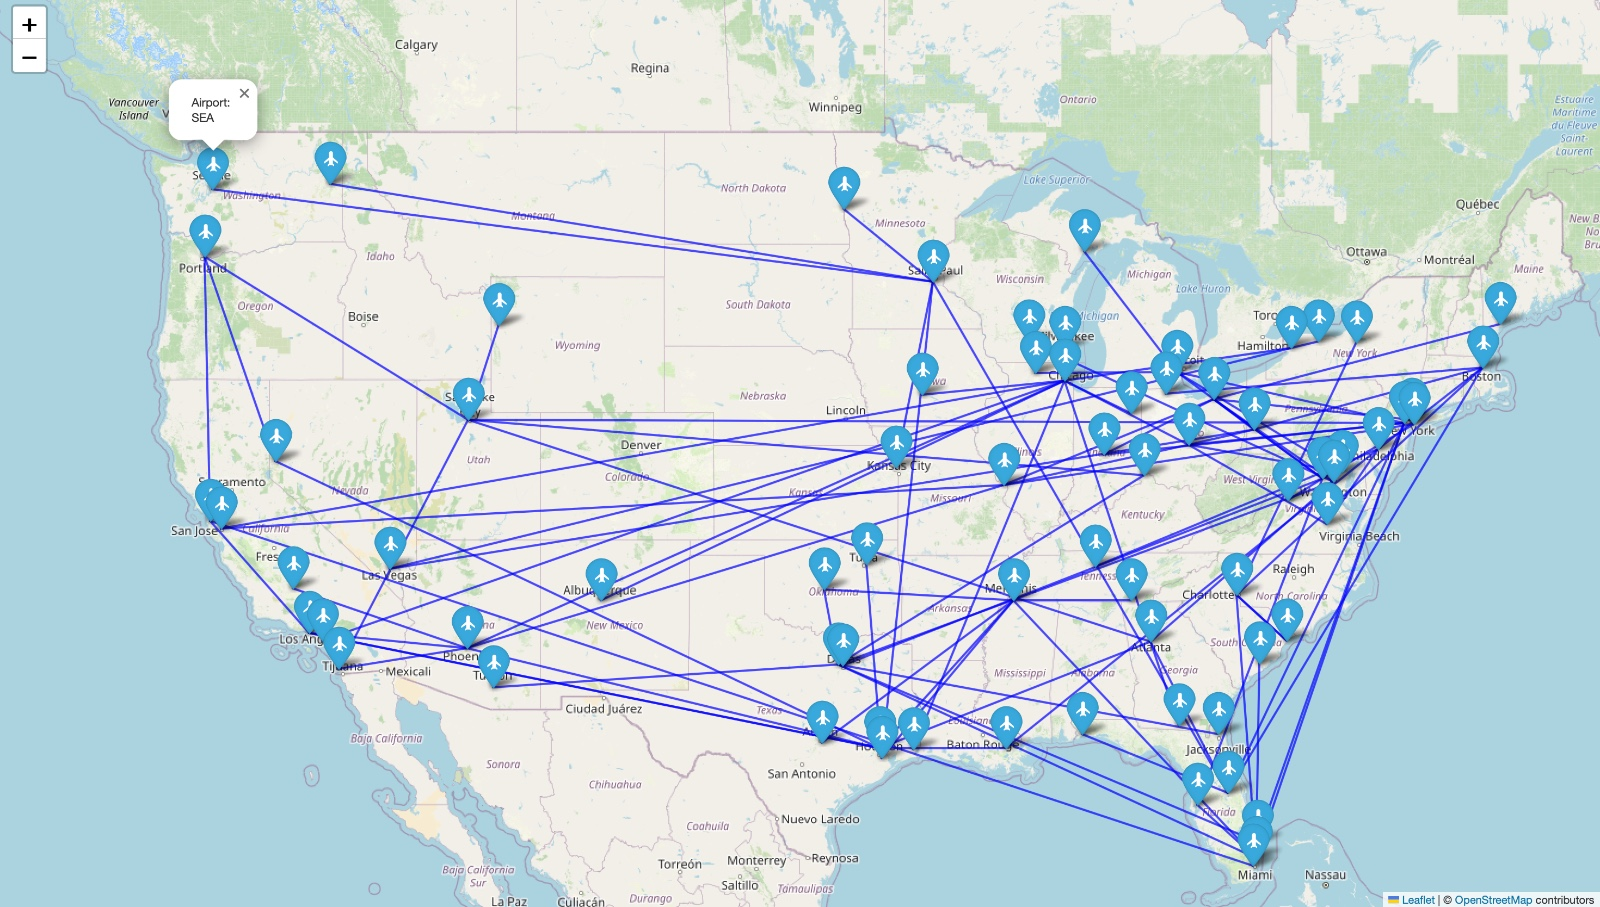

In [1]:
from IPython.display import Image
Image('/content/Example_map.jpeg')


We decided to only show a small part of the routes in order to make the image more readable.

---

## Answer Questions:

-**Graph Density**: The graph density is around 0.07, this means that approximately 7% of all possible edges are present in the graph. Thus the graph is relatively sparse.<br>
-**Degree Distribution**:A really small number of nodes have a very high degree, and a large number of nodes have a low degree.<br>
-**Hubs**:
Airports identified as hubs: ['SEA', 'PDX', 'SFO', 'LAX', 'FLL', 'PHX', 'TUS', 'DFW', 'SLC', 'RNO', 'ABQ', 'LAS', 'ICT', 'OKC', 'SAN', 'OAK', 'IAH', 'ELP', 'TUL', 'OMA', 'AUS', 'COS', 'MSN', 'RFD', 'MKE', 'DSM', 'LIT', 'SHV', 'MCI', 'SAT', 'MSP', 'ORD', 'STL', 'BNA', 'MEM', 'IND', 'LRD', 'CLE', 'DTW', 'DAY', 'CVG', 'CMH', 'FWA', 'HOU', 'TOL', 'PIT', 'BOS', 'ATL', 'MDW', 'PHL', 'GSO', 'BUF', 'EWR', 'CLT', 'JFK', 'GRR', 'YIP', 'LGA', 'LEX', 'BHM', 'MCO', 'IAD', 'MSY', 'RDU', 'GSP', 'BDL', 'CAE', 'BWI', 'TYS', 'MIA', 'TPA', 'DAL', 'JAX']<br>
-For **Busiest Routes** and **Under/Over-Utilized routes** take a look at the tables presented above.<br>

**QUESTION 4**

In [ ]:
import sys
sys.path.append('/kaggle/input/functions2')


to answer question 4, I don't apply an randomized mincut algorithm because it does not guarantee the correctness of result, but it give a probably correct result depending on the number of attempts. We need a more deterministic solution, so I decide to applicate an approach that examines all combinations of edges to find the set of edges whose removal disconnects the graph into two connected components.


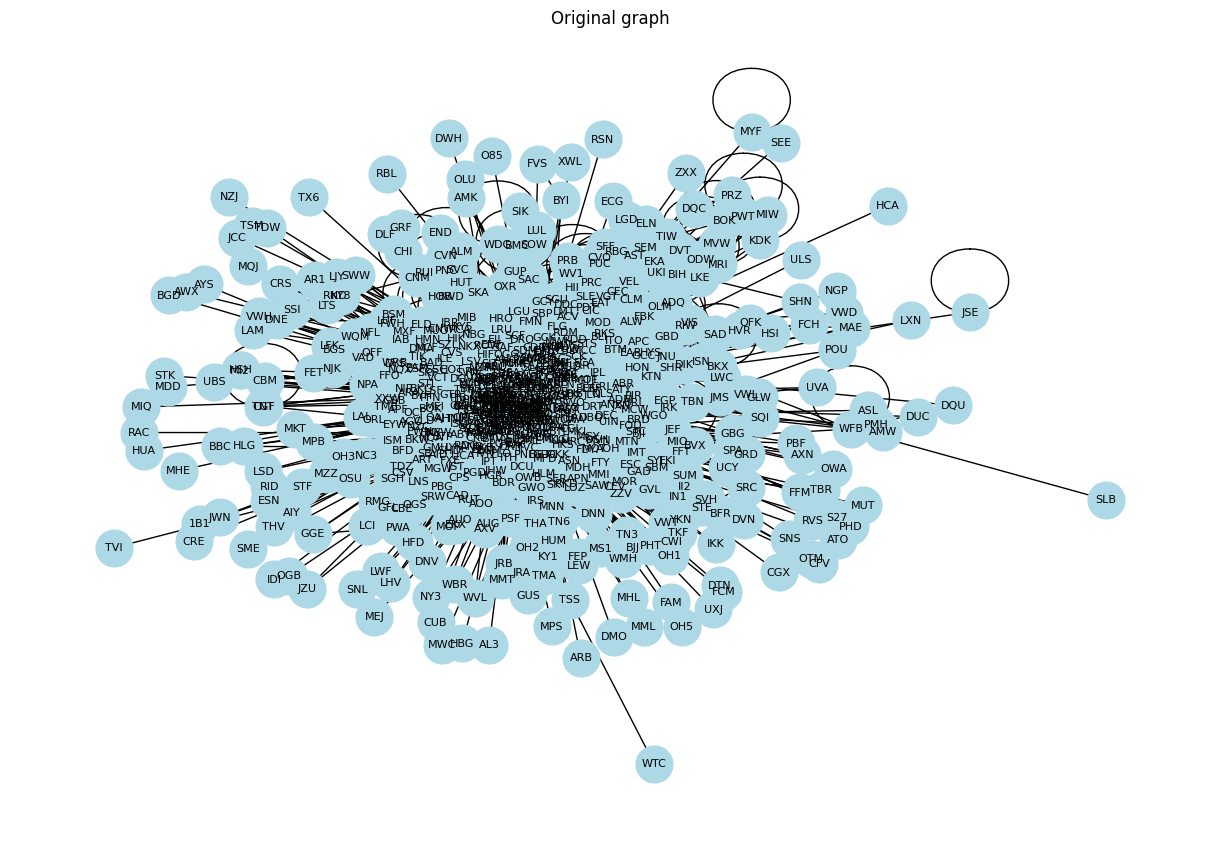

Number of edges removed after cut: 1


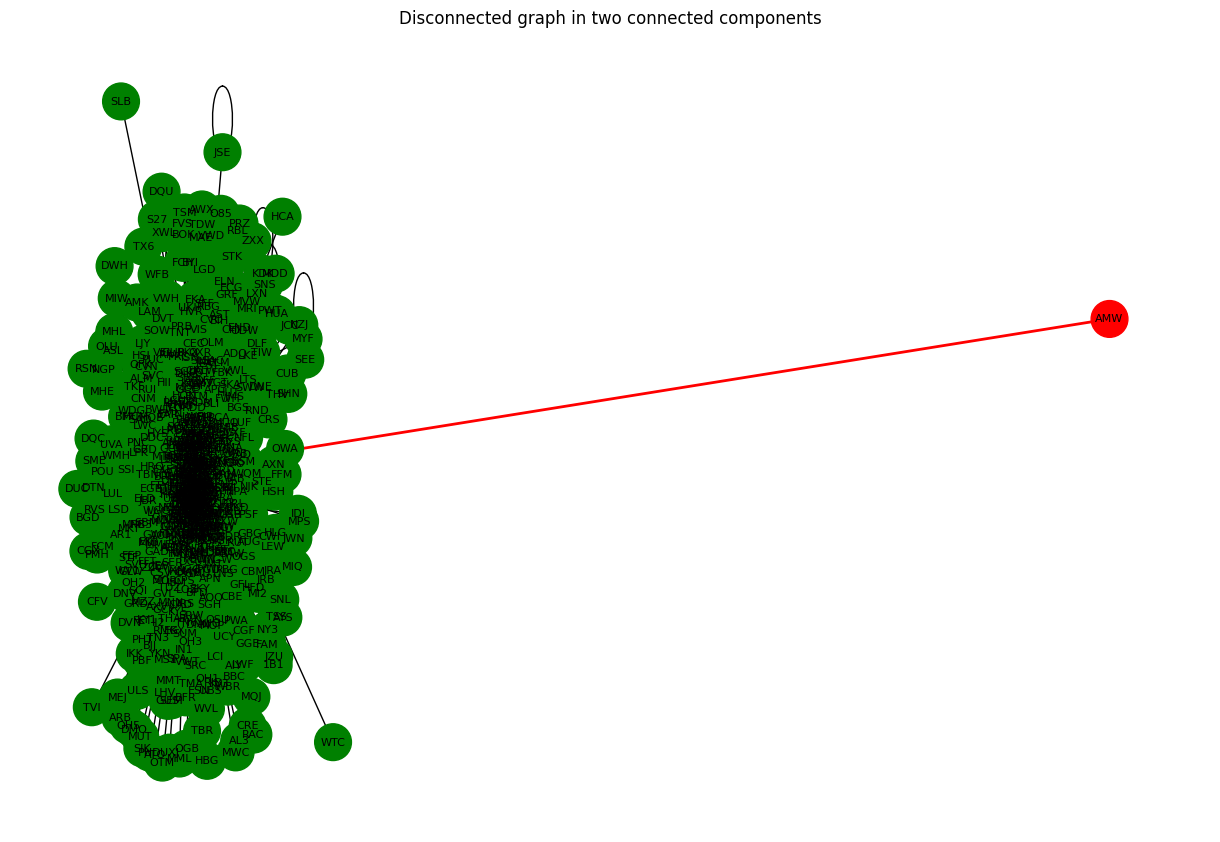

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from functions import visualize_graph
from functions import MinCut
#import dataset
df=pd.read_csv('/kaggle/input/usa-airport-dataset/Airports2.csv')
#create graph employing data of flights
G=nx.from_pandas_edgelist(df,source='Origin_airport',target='Destination_airport')

#visualize original graph
visualize_graph(G,'Original graph')

#find minimum cut(set of edges to remove)
mincut_set=MinCut(G)
#remove the minimum set of edges found to divide the graph into two disconnetted components
G.remove_edges_from(mincut_set)
#print the number of flights removed to disconnect the graph
print("Number of edges removed after cut:",len(mincut_set))

#visualize the graph with two connected components highlighted
components=list(nx.connected_components(G))
color=[]
for node in G.nodes():
    if node in components[0]:
        color.append('green')
    else:
        color.append('red')

visualize_graph(G,'Disconnected graph in two connected components',node_color=color,highlighted_edges=mincut_set)


the results of this approach provides two components:  one consisting of a single node and the other from n-1 nodes... this is likely due to the sparse nature of the graph. To verify if the mincut function provides the correct results we can test the function on some examples of graphs and check whether it identifies the minimum set of edges whose removal disconnects the graph into two connected components.

Number of edges removed after cut: 1


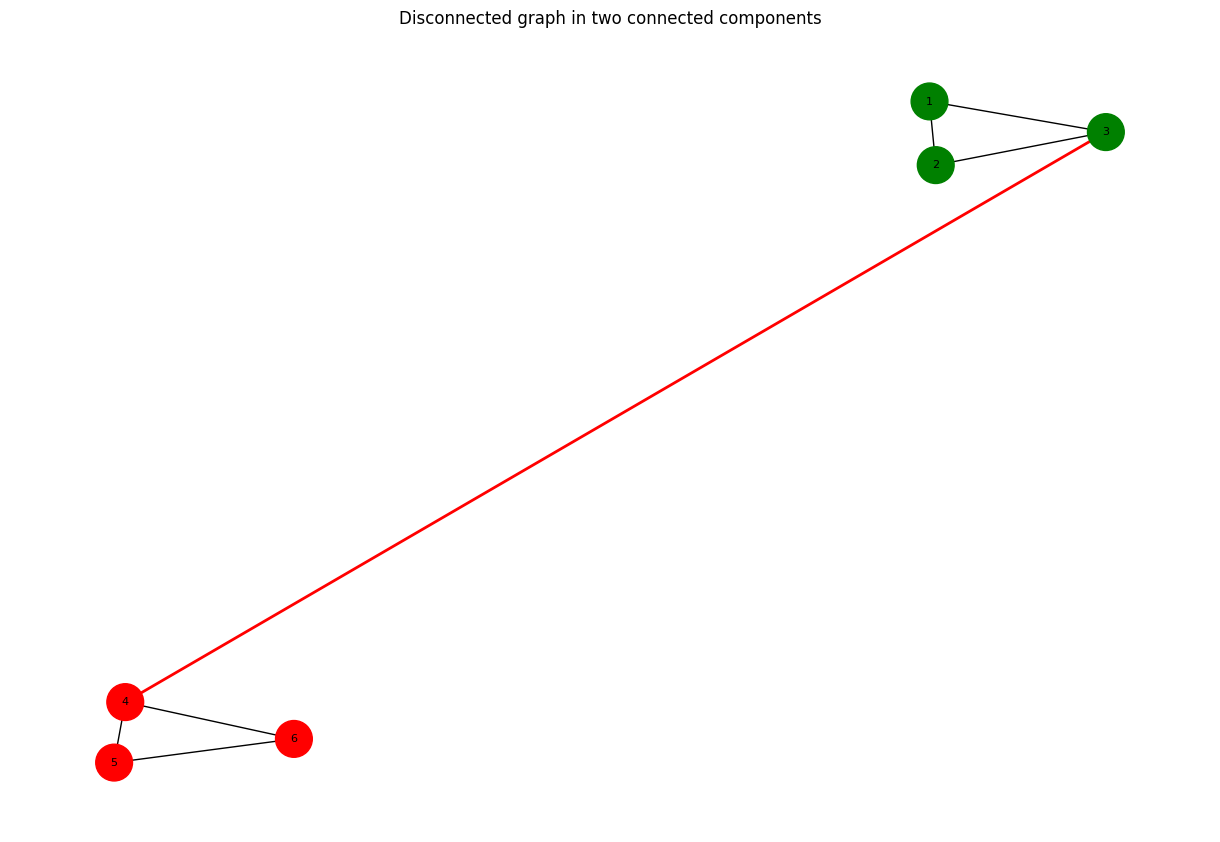

In [ ]:
# create example graph
example=nx.Graph()
example.add_edges_from([(1,2),(2,3),(3,1)])
example.add_edges_from([(4,5),(5,6),(6,4)])
example.add_edge(3,4)
#find minimum cut(set of edges to remove)
mincut_set=MinCut(example)
#remove the minimum set of edges found to divide the graph into two disconnetted components
example.remove_edges_from(mincut_set)
#print the number of flights removed to disconnect the graph
print("Number of edges removed after cut:",len(mincut_set))

#visualize the graph with two connected components highlighted
components=list(nx.connected_components(example))
color=[]
for node in example.nodes():
    if node in components[0]:
        color.append('green')
    else:
        color.append('red')

visualize_graph(example,'Disconnected graph in two connected components',node_color=color,highlighted_edges=mincut_set)


Number of edges removed after cut: 1
Edges removed: [(4, 5)]


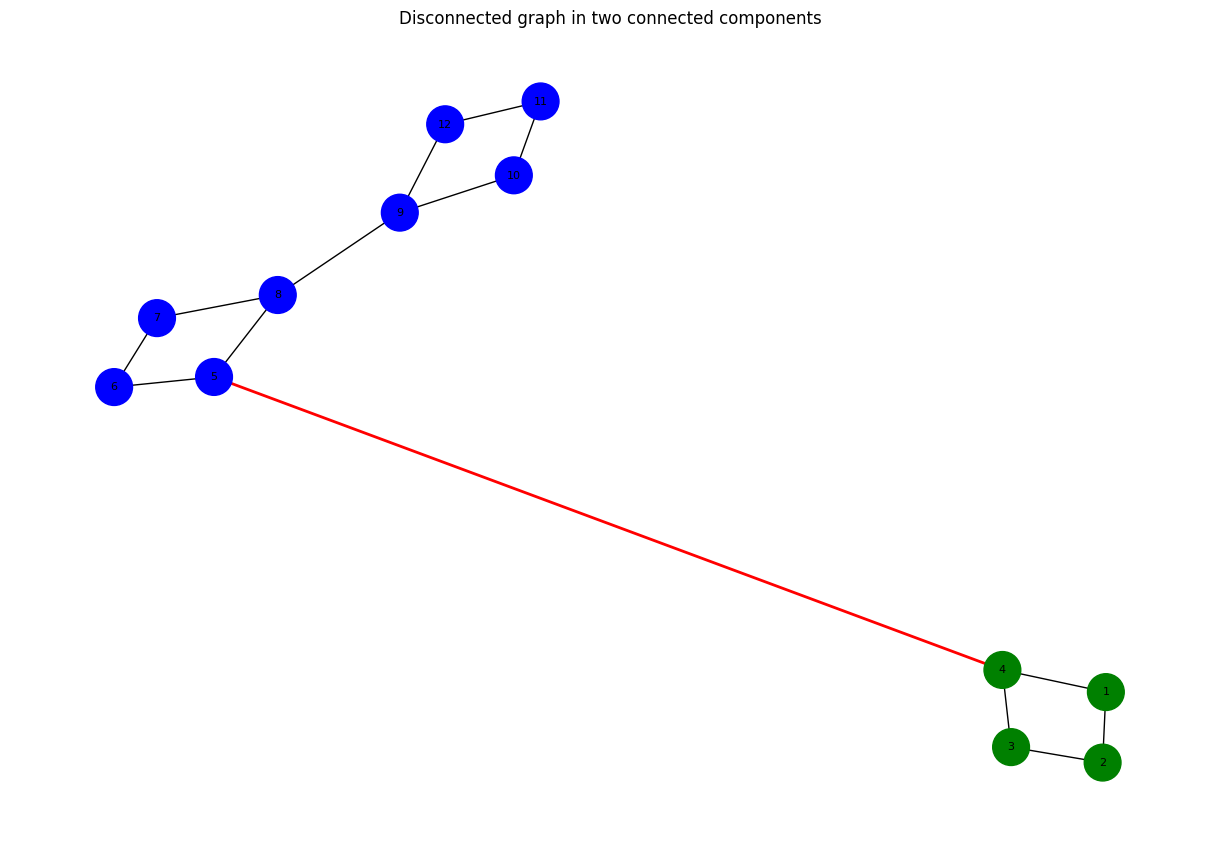

In [ ]:
# create example graph
example=nx.Graph()
example.add_edges_from([(1,2),(2,3),(3,4),(4,1)])
example.add_edges_from([(5,6),(6,7),(7,8),(8,5)])
example.add_edges_from([(9,10),(10,11),(11,12),(12,9)])
example.add_edge(4,5)
example.add_edge(8,9)

#find minimum cut(set of edges to remove)
mincut_set=MinCut(example)
#remove the minimum set of edges found to divide the graph into two disconnetted components
example.remove_edges_from(mincut_set)
#print the number and the flights removed to disconnect the graph
print("Number of edges removed after cut:",len(mincut_set))
print("Edges removed:",mincut_set)

#visualize the graph with two connected components highlighted
components=list(nx.connected_components(example))
color=[]
for node in example.nodes():
    if node in components[0]:
        color.append('green')
    else:
        color.append('blue')

visualize_graph(example,'Disconnected graph in two connected components',node_color=color,highlighted_edges=mincut_set)


**QUESTION 5**

Girvan-Newman: 4 communities detected in 41.79 seconds
Girvan-Newman Communities:
Community 1: ['Carbondale, IL', 'Meadville, PA', 'La Grande, OR', 'Panama City, FL', 'Eau Claire, WI', 'Alamogordo, NM', 'Cleveland, OH', 'Worcester, MA', 'La Crosse, WI', 'Macon, GA', 'Madera, CA', 'San Francisco, CA', 'Jamestown, NY', 'Paris, TN', 'Pendleton, OR', 'Laconia, NH', 'Elkhart, IN', 'New Haven, CT', 'Andrews, TX', 'St. Cloud, MN', 'Tulsa, OK', 'Fresno, CA', 'Jonesboro, AR', 'Silver City, NM', 'Cape Girardeau, MO', 'Danville, KY', 'Montgomery, AL', 'Anchorage, AK', 'Traverse City, MI', 'Minot, ND', 'Show Low, AZ', 'Norfolk, NE', 'Walla Walla, WA', 'Lexington, KY', 'Modesto, CA', 'Marshall, TX', 'Gary, IN', 'Tucson, AZ', 'Rutland, VT', 'Sturgis, MI', 'Athens, GA', 'Pierre, SD', 'Nashville, TN', 'Hagerstown, MD', 'Yankton, SD', 'Roanoke, VA', 'Dayton, OH', 'Wichita Falls, TX', 'Sikeston, MO', 'Pine Bluff, AR', 'Sioux Falls, SD', 'Twin Falls, ID', 'Watertown, NY', 'Sandusky, OH', 'Bangor, ME', 'C

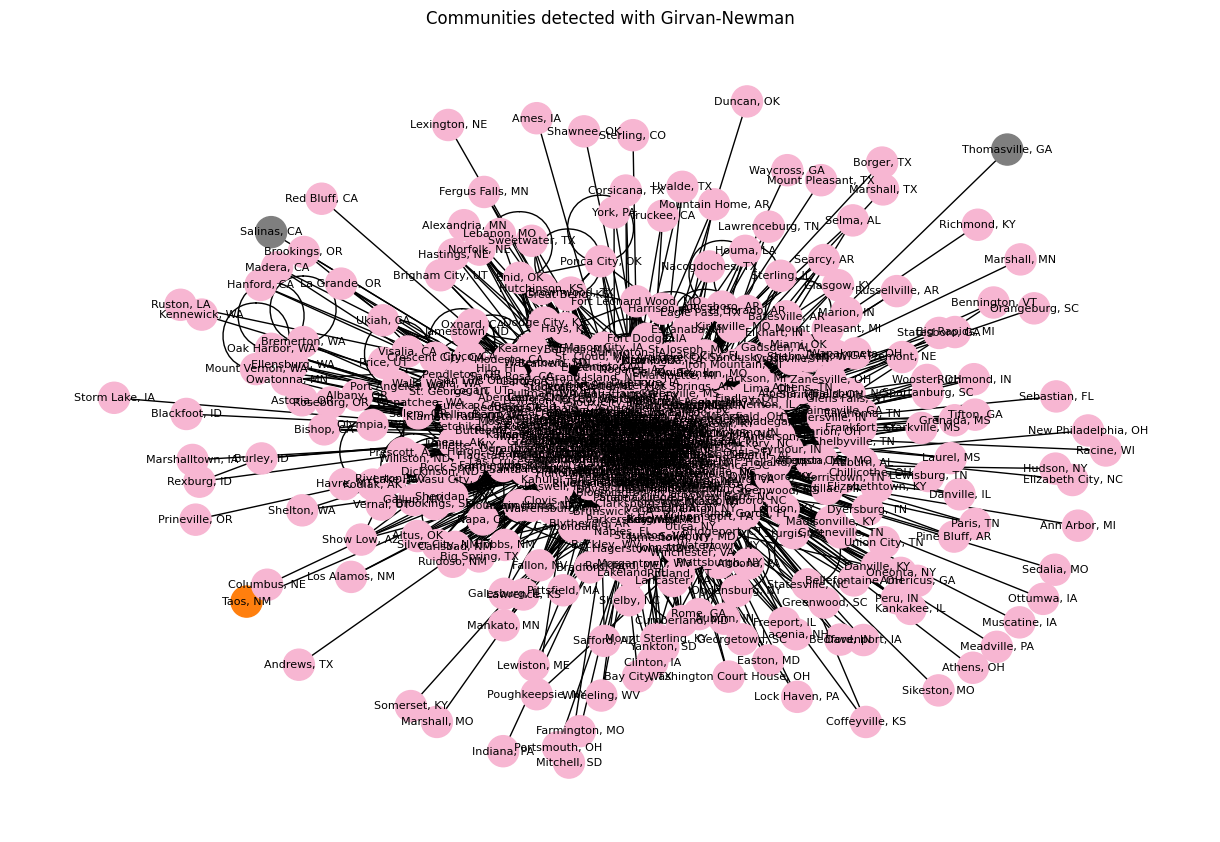

Louvain Communities:
Community 1: ['Manhattan, KS', 'Ames, IA', 'Wichita, KS', 'Oklahoma City, OK', 'Dubuque, IA', 'Peoria, IL', 'Wausau, WI', 'Topeka, KS', 'North Platte, NE', 'Liberal, KS', 'Madison, WI', 'Lincoln, NE', 'Waterloo, IA', 'Rockford, IL', 'La Crosse, WI', 'Milwaukee, WI', 'Fort Dodge, IA', 'Des Moines, IA', 'Mason City, IA', 'Kansas City, MO', 'Springfield, MO', 'Grand Island, NE', 'Cedar Rapids, IA', 'Sioux City, IA', 'Garden City, KS', 'Springfield, IL', 'Decatur, IL', 'Chicago, IL', 'Gary, IN', 'St. Louis, MO', 'Evansville, IN', 'Champaign, IL', 'Indianapolis, IN', 'Bloomington, IL', 'Detroit, MI', 'Fort Wayne, IN', 'Salina, KS', 'Quincy, IL', 'Ponca City, OK', 'Enid, OK', 'Harrison, AR', 'Dodge City, KS', 'Lansing, MI', 'Bowling Green, KY', 'London, KY', 'Winchester, VA', 'Columbus, IN', 'Bloomington, IN', 'Mansfield, OH', 'Madisonville, KY', 'Terre Haute, IN', 'Great Bend, KS', 'Hays, KS', 'Kearney, NE', 'Burlington, IA', 'Joplin, MO', 'Fort Leonard Wood, MO', 'Lima

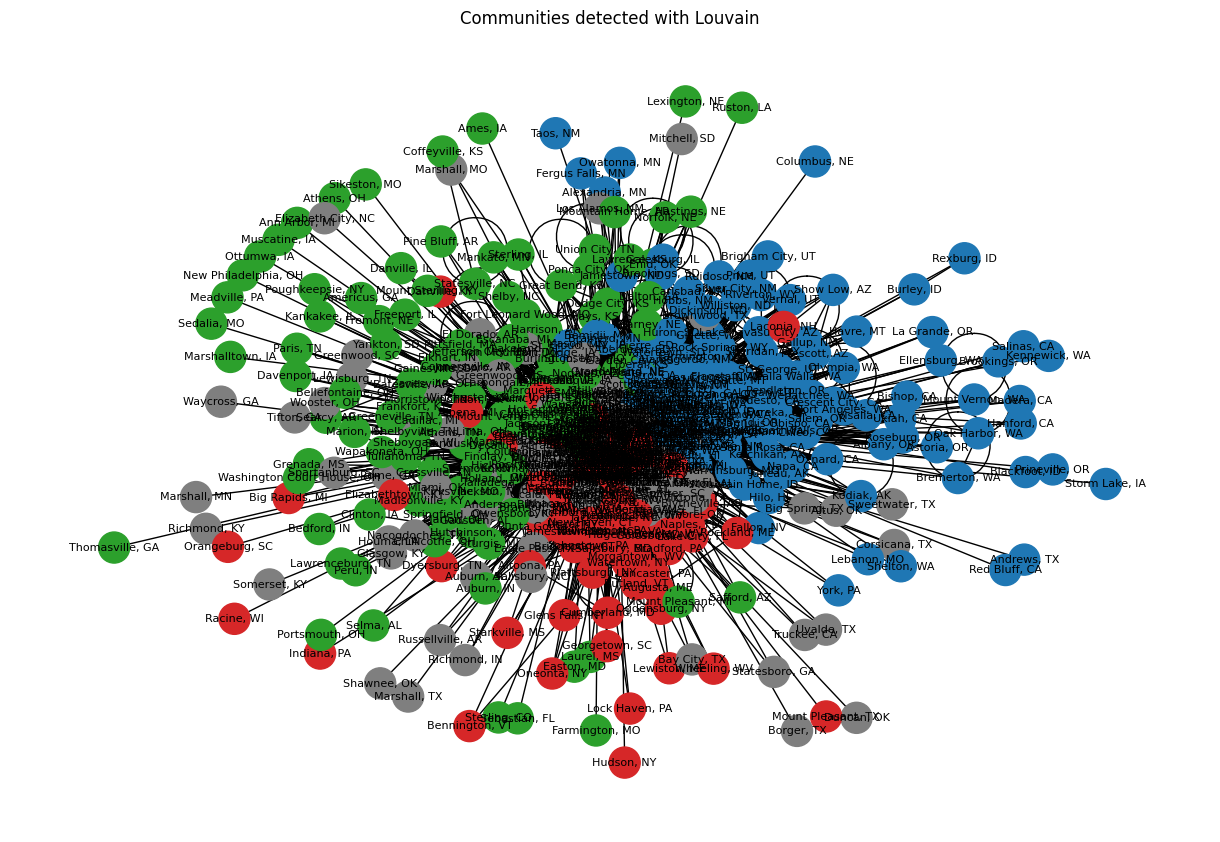

Write here the first city:  Manhattan, KS
Write here the second city:  Waycross, GA


Girvan-Newman: Manhattan, KS and Waycross, GA are in the same community.
Louvain: Manhattan, KS and Waycross, GA are not in the same community.


In [ ]:
!pip install python-louvain
import community.community_louvain as community_louvain
import time
import random
from collections import defaultdict
from functions import visualize_communities,girvan_newman,are_in_same_community

#import dataset
df=pd.read_csv('/kaggle/input/usa-airport-dataset/Airports2.csv')

#create graph employing cities as nodes
G=nx.from_pandas_edgelist(df, source='Origin_city', target='Destination_city')

# apply Girvan-Newman
start_time=time.time()
girvan_communities=girvan_newman(G,4)
girvan_time=time.time()-start_time

print(f"Girvan-Newman: {len(girvan_communities)} communities detected in {girvan_time:.2f} seconds")
print("Girvan-Newman Communities:")
for i in range(len(girvan_communities)):
    print(f"Community {i + 1}: {list(girvan_communities[i])}")
visualize_communities(G,girvan_communities,"Communities detected with Girvan-Newman")

# Methods Louvain suggested from LLM
start_time=time.time()
partition=community_louvain.best_partition(G)  # find communities with Louvain
louvain_communities=defaultdict(list)
for node, id_communities in partition.items():
    louvain_communities[id_communities].append(node)
louvain_time=time.time()-start_time

louvain_communities_list=list(louvain_communities.values())
print("Louvain Communities:")
for i in range(len(louvain_communities_list)):
    print(f"Community {i + 1}: {louvain_communities_list[i]}")
print(f"Louvain: {len(louvain_communities_list)} communities detected in {louvain_time:.2f} seconds")

visualize_communities(G,louvain_communities_list,"Communities detected with Louvain")

#choose two cities '
city1=input("Write here the first city: ")
city2=input("Write here the second city: ")

#verify if two cities are in the same communities for girvan newman
verify_girvan=are_in_same_community(city1,city2,girvan_communities)
#verify if two cities are in the same communities for louvain
verify_louvain=any(city1 in i and city2 in i for i in louvain_communities_list)

print(f"Girvan-Newman: {city1} and {city2} {'are' if verify_girvan else 'are not'} in the same community.")
print(f"Louvain: {city1} and {city2} {'are' if verify_louvain else 'are not'} in the same community.")


We employed the girvan newman algorithm to detect communities as suggested by the provided link. This algorithm recursively removes edges with the highest betweenness centrality to identify communities. Additionally we utilized the Louvain algorithm as recommended by the LLM.
We set for girvan newman to stop once it detected four communities, matching the number of communities identified by the Louvain algorithm.

The first difference we observed in the results of these two algorithms is that the Girvan Newman algorithm detected first 4 communities composed each composed of only a single node. In contrast, the Louvain algorithm detected four well populated communities comprising a significant number of cities. This discrepancy is likely due to the sparse nature and topology of the graph, where an algorithm based on modularity, such as the Louvain algorithm, is more appropriate.
In fact the Girvan newman algorithm focuses on removing edges with high betweenness centrality but does not directly optimize the quality of the resulting communities. On the other hand Louvain explicitly aims to maximize modularity, which makes it more effective for sparse graphs.
Another difference we noted is in their performance. The Louvain algorithm is significantly faster than the Girvan Newman algorithm, making Girvan Newman more suitable for small or medium sized graphs, while Louvain is wellsuited for both small and large graphs.


## Bonus Question - Connected Components on MapReduce

### MapReduce is ideal for network analysis as it enables parallel processing of large graph datasets, making it scalable and efficient. By breaking tasks into map and reduce steps, it allows for distributed analysis of networks, which is essential for handling large-scale graph problems like connected components.

### 1. In this task, you are required to use PySpark and the MapReduce paradigm to identify the connected components in a flight network graph. The focus should be on airports rather than cities. As you know, a connected component refers to a group of airports where every pair of airports within the group is connected either directly or indirectly.

### The function takes the following inputs:

### 1. Flight network
### 2. A starting date
### 3. An end date

### The function outputs:
### 1. The number of the connected components during that period
### 2. The size of each connectd componenet
### 3. The airports within the largest connected component identified.

### **Note**: For this task, you should check if there is a flight between two airports during that period. Note: You are not allowed to use pre-existing packages or functions in PySpark; instead, you must implement the algorithm from scratch using the MapReduce paradigm.

#### Mounting Google Drive and Installing Necessary Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install PySpark and all the necessary packages
! pip install pyngrok gdown  pyspark  yellowbrick graphframes

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark import SparkContext, StorageLevel
from pyspark.sql.functions import col, explode, collect_list, min, to_date as spark_min, struct, size, row_number, to_date
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from graphframes import GraphFrame
import time
import json
import tempfile
import os

In [ ]:
# Get the active SparkContext instance
sc = SparkContext.getOrCreate()

# Stop SparkContext if you want to create a new one
sc.stop()

# Initialize Spark Session with configurations
print("Initializing Spark Session...")
spark = SparkSession.builder \
    .appName("Connected Components Analysis") \
    .config("spark.driver.memory", "15g") \
    .config("spark.executor.memory", "15g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()
print("... Spark Session Created")
sc = spark.sparkContext

Initializing Spark Session...
... Spark Session Created


#### Loading and Preparing the Flight Network Dataset

We perform the following operations to load and prepare the flight network dataset for analysis:

1. **Loading the Dataset with Pandas**;

2. **Converting Pandas DataFrame to Spark DataFrame**;

3. **Displaying the Schema of the Spark DataFrame**.



In [ ]:
# Load the dataset as a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Airports2.csv')
flight_network_df = spark.createDataFrame(df)

# Display the schema to confirm
flight_network_df.printSchema()

root
 |-- Origin_airport: string (nullable = true)
 |-- Destination_airport: string (nullable = true)
 |-- Origin_city: string (nullable = true)
 |-- Destination_city: string (nullable = true)
 |-- Passengers: long (nullable = true)
 |-- Seats: long (nullable = true)
 |-- Flights: long (nullable = true)
 |-- Distance: long (nullable = true)
 |-- Fly_date: string (nullable = true)
 |-- Origin_population: long (nullable = true)
 |-- Destination_population: long (nullable = true)
 |-- Org_airport_lat: double (nullable = true)
 |-- Org_airport_long: double (nullable = true)
 |-- Dest_airport_lat: double (nullable = true)
 |-- Dest_airport_long: double (nullable = true)



We define two crucial functions, `propagate_labels` and `identify_connected_components_rdd`, which work together to identify connected components within a flight network dataset using Spark's Resilient Distributed Datasets (RDDs). This approach leverages low-level Spark transformations and actions for efficient graph processing.
- The `propagate_labels` function is a helper function designed to facilitate the iterative process of label propagation, a key step in identifying connected components within a graph. By propagating the smallest label across connected nodes, the function ensures that all nodes within the same connected component eventually share the same label.
- The `identify_connected_components_rdd` function is designed to identify connected components within a flight network dataset over a specified date range using Spark's RDD API. Connected components represent groups of airports where each airport is reachable from any other airport within the same group, indicating a fully interconnected sub-network.


In [ ]:
import builtins
from pyspark.sql.functions import to_date, col
from pyspark import StorageLevel
import time

def propagate_labels(labels_rdd, graph_rdd):
    """
    Propagates labels through the graph to identify connected components.

    Parameters:
    - labels_rdd (RDD of tuples): Current labels as (airport_id, label_id).
    - graph_rdd (RDD of tuples): Graph edges as (airport_id, list of neighbor_ids).

    Returns:
    - new_labels (RDD of tuples): Updated labels after propagation as (airport_id, new_label_id).
    """
    # Join graph with current labels to get the label of each airport's neighbors
    joined = graph_rdd.join(labels_rdd)

    # Create messages to propagate the smallest label to each neighbor
    messages = joined.flatMap(lambda x: [(neighbor, x[1][1]) for neighbor in x[1][0]])

    # Combine incoming messages with existing labels and choose the minimum label
    new_labels = messages.union(labels_rdd).reduceByKey(lambda a, b: builtins.min(a, b))

    return new_labels

def identify_connected_components_rdd(flight_network_df, start_date, end_date):
    """
    Identifies the connected components in the flight network between start_date and end_date.

    Parameters:
    - flight_network_df (DataFrame): Spark DataFrame containing flight data with columns
                                      'Origin_airport', 'Destination_airport', 'Fly_date'.
    - start_date (str): Start date of the period in 'YYYY-MM-DD' format.
    - end_date (str): End date of the period in 'YYYY-MM-DD' format.

    Returns:
    - num_connected_components (int): Number of connected components.
    - component_sizes_sorted (list of tuples): List of component sizes sorted in descending order.
    - largest_component_airports (list): List of airports in the largest connected component.
    - execution_time (float): Time taken to execute the function in seconds.
    """

    # Filter flights within the specified date range and drop rows with null airports
    filtered_df = flight_network_df.filter(
        (col("Fly_date") >= start_date) & (col("Fly_date") <= end_date)
    ).na.drop(subset=["Origin_airport", "Destination_airport"])

    # Create edges by selecting origin and destination airports and ensuring uniqueness
    edges = filtered_df.select(
        col("Origin_airport").alias("src"),
        col("Destination_airport").alias("dst")
    ).rdd.map(lambda row: (row["src"], row["dst"])).distinct()

    # Create reverse edges to make the graph undirected
    reverse_edges = edges.map(lambda edge: (edge[1], edge[0]))
    all_edges = edges.union(reverse_edges).distinct()

    # Extract all unique airports from the edges
    airports = all_edges.flatMap(lambda edge: edge).distinct()

    # Assign unique IDs to each airport
    airport_id = airports.zipWithIndex().map(lambda x: (x[0], x[1]))
    id_to_airport = airport_id.map(lambda x: (x[1], x[0])).collectAsMap()
    airport_id_dict = airport_id.collectAsMap()

    # Broadcast the ID mappings for efficient access across the cluster
    broadcast_id_to_airport = flight_network_df.sparkSession.sparkContext.broadcast(id_to_airport)
    broadcast_airport_id = flight_network_df.sparkSession.sparkContext.broadcast(airport_id_dict)

    # Map edges using the integer IDs
    all_edges_id = all_edges.map(lambda x: (broadcast_airport_id.value[x[0]], broadcast_airport_id.value[x[1]])).distinct()

    # Build the graph as an RDD of (airport, list of neighbors)
    graph = all_edges_id.groupByKey().mapValues(list).persist(StorageLevel.MEMORY_AND_DISK)

    start_time = time.time()

    # Initialize labels: each airport's label is its own ID initially
    labels = all_edges_id.flatMap(lambda x: [x[0], x[1]]).distinct().map(lambda airport: (airport, airport)).persist(StorageLevel.MEMORY_AND_DISK)

    # Iteratively propagate labels until convergence or maximum iterations are reached
    current_labels = labels
    prev_labels = None
    iteration = 0
    MAX_ITERATIONS = 100  # Limit to prevent infinite loops

    while iteration < MAX_ITERATIONS:
        iteration += 1
        print(f"Iteration {iteration}")

        # Propagate labels
        new_labels = propagate_labels(current_labels, graph).persist(StorageLevel.MEMORY_AND_DISK)

        # Check for convergence by comparing with previous labels
        if prev_labels:
            differences = current_labels.join(new_labels) \
                .filter(lambda x: x[1][0] != x[1][1]) \
                .count()
            print(f"Differences from the previous iteration: {differences}")
            if differences == 0:
                print("Convergence achieved.")
                break
        else:
            print("First iteration, no comparison.")

        # Unpersist previous labels to free up memory
        if prev_labels:
            prev_labels.unpersist()

        # Update labels for the next iteration
        prev_labels = current_labels
        current_labels = new_labels

    # Warn if maximum iterations were reached without convergence
    if iteration == MAX_ITERATIONS:
        print("Warning: Maximum number of iterations reached without convergence.")

    end_time = time.time()
    execution_time = end_time - start_time

    # Collect the final labels
    final_labels = current_labels

    # Count the number of distinct connected components
    num_connected_components = final_labels.map(lambda x: x[1]).distinct().count()

    # Count the number of airports in each connected component
    component_sizes = final_labels.map(lambda x: (x[1], 1)).reduceByKey(lambda a, b: a + b).collect()

    # Sort the component sizes in descending order
    component_sizes_sorted = sorted(component_sizes, key=lambda x: x[1], reverse=True)

    # Identify the largest connected component
    if component_sizes_sorted:
        largest_component_label = component_sizes_sorted[0][0]
        largest_component_size = component_sizes_sorted[0][1]

        # Filter airports belonging to the largest connected component
        largest_component_airports = final_labels.filter(lambda x: x[1] == largest_component_label) \
            .map(lambda x: broadcast_id_to_airport.value[x[0]]).collect()
    else:
        largest_component_label = None
        largest_component_size = 0
        largest_component_airports = []

    return num_connected_components, component_sizes_sorted, largest_component_airports, execution_time


We execute the connected components analysis on the flight network dataset for the specified date range. The steps include:

1. **Defining the Analysis Period:**
   - Setting the start and end dates for the analysis.

2. **Data Preparation:**
   - Converting the `'Fly_date'` column to a proper date format to ensure accurate filtering.

3. **Identifying Connected Components:**
   - Utilizing the `identify_connected_components_rdd` function to determine the connected components within the defined date range.

4. **Displaying the Results:**
   - Printing the total number of connected components.
   - Listing the sizes of each connected component in descending order.
   - Enumerating the airports that belong to the largest connected component.
   - Showing the execution time of the analysis.


In [ ]:
# Define the start and end dates for the analysis period
start_date = "2000-01-01"
end_date = "2000-05-31"

# Convert the 'Fly_date' column to a date type with the specified format
#flight_network_df = flight_network_df.withColumn("Fly_date", to_date(col("Fly_date"), "yyyy-MM-dd"))

# Identify connected components within the specified date range using the previously defined function
num_connected_components, component_sizes_sorted, largest_component_airports, execution_time = identify_connected_components_rdd(flight_network_df, start_date, end_date)

Iteration 1
First iteration, no comparison.
Iteration 2
Differences from the previous iteration: 208
Iteration 3
Differences from the previous iteration: 16
Iteration 4
Differences from the previous iteration: 0
Convergence achieved.


In [ ]:
# Print the results of the connected components analysis
print("\n===== Connected Components Analysis =====\n")

# Print the number of connected components found within the specified date range
print(f"Number of connected components between {start_date} and {end_date}: {num_connected_components}\n")

# Print the sizes of each connected component, sorted in descending order
print("Sizes of each connected component (sorted in descending order):")
for idx, (component, size) in enumerate(component_sizes_sorted, start=1):
    print(f"{idx}. Component {component}: {size} airports")
print()

# Print the list of airports that belong to the largest connected component
print("Airports in the largest connected component:")
print(", ".join(f"{airport}" for airport in largest_component_airports))

# Print the execution time of the connected components analysis
print(f"Execution time: {execution_time}\n")


===== Connected Components Analysis =====

Number of connected components between 2000-01-01 and 2000-05-31: 2

Sizes of each connected component (sorted in descending order):
1. Component 0: 298 airports
2. Component 227: 2 airports

Airports in the largest connected component:
IND, JAX, SEA, FOE, JBR, RDU, TYS, EKO, EAT, CWA, IAD, MCO, MSN, SAV, FOD, PIT, BDL, ATL, FSM, DEC, JFK, DTW, BIL, ROC, DRT, ELP, YIP, SYR, JAC, SBP, MSP, BOS, BTR, LNK, DRO, SBA, BTV, SFB, MLU, EYW, TPA, ACT, BRD, ITH, UIN, SAT, CAK, STC, BIS, GUP, FAR, TUS, LCK, LCH, MKL, SHV, JNU, SFO, PWM, ICT, HNL, FLL, BMI, ALO, YUM, LAX, EWR, KTN, OGG, BRL, IAH, MEM, AVL, DHN, MRC, ORD, HLN, CRW, LBL, PAH, LAS, CAE, AZO, CHA, BVX, PBI, GEG, LIT, RST, BYH, ACY, OKC, DFW, MOB, ATY, GPT, RNO, YNG, PIR, CGI, MSY, SLC, SPI, TYR, SLN, GRR, AGS, OAK, EAU, APN, RDD, BLI, FAY, BJI, MMI, GSO, CMH, SMF, GJT, LRD, SAN, MBS, LBB, OGD, PNS, CLT, STL, MAF, TLH, ITO, BGR, RIC, BTM, ABQ, FLO, DCA, CLE, DET, LEX, CPR, SJC, MYR, FNT, ELM,

### 2. Compare the execution time and the results of your implementation with those of the GraphFrames package for identifying connected components. If there is any difference in the results, provide an explanation for why that might occur.


We create a new Spark session configured with GraphFrames to perform connected components analysis on the flight network dataset. This setup enables us to leverage graph-based processing capabilities for a more efficient and comprehensive analysis.

In [ ]:
# Obtain the active SparkContext instance
sc = SparkContext.getOrCreate()

# Stop the SparkContext if you wish to create a new one
sc.stop()

# Initialize Spark Session with configurations
print("Initializing Spark Session...")

spark = SparkSession.builder \
        .appName("GraphFramesExample") \
        .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.0-s_2.12") \
        .config("spark.driver.memory", "15g") \
        .config("spark.executor.memory", "15g") \
        .config("spark.sql.shuffle.partitions", "100") \
        .getOrCreate()

print("... Spark Session Created")
sc = spark.sparkContext

Initializing Spark Session...
... Spark Session Created


#### Loading and Preparing the Flight Network Dataset

In [ ]:
# Load the dataset as a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Airports2.csv')
flight_network_df = spark.createDataFrame(df)

# Display the schema to confirm
flight_network_df.printSchema()

root
 |-- Origin_airport: string (nullable = true)
 |-- Destination_airport: string (nullable = true)
 |-- Origin_city: string (nullable = true)
 |-- Destination_city: string (nullable = true)
 |-- Passengers: long (nullable = true)
 |-- Seats: long (nullable = true)
 |-- Flights: long (nullable = true)
 |-- Distance: long (nullable = true)
 |-- Fly_date: string (nullable = true)
 |-- Origin_population: long (nullable = true)
 |-- Destination_population: long (nullable = true)
 |-- Org_airport_lat: double (nullable = true)
 |-- Org_airport_long: double (nullable = true)
 |-- Dest_airport_lat: double (nullable = true)
 |-- Dest_airport_long: double (nullable = true)



We define the `identify_connected_components_graphframes` function, which leverages GraphFrames to identify connected components within the flight network dataset over a specified date range. This function filters the relevant flight data, constructs a graph of airports, computes the connected components, and returns key metrics such as the number of connected components, their sizes, the airports in the largest connected component, and the execution time of the analysis.


In [ ]:
from graphframes import GraphFrame

def identify_connected_components_graphframes(flight_network_df, start_date, end_date):
    """
    Identifies the connected components in the flight network between start_date and end_date using GraphFrames.

    Parameters:
    - flight_network_df (DataFrame): Spark DataFrame containing flight data with columns
                                     'Origin_airport', 'Destination_airport', 'Fly_date'.
    - start_date (str): Start date of the period in 'YYYY-MM-DD' format.
    - end_date (str): End date of the period in 'YYYY-MM-DD' format.

    Returns:
    - num_connected_components (int): Number of connected components.
    - component_sizes_sorted (list of tuples): List of component sizes sorted in descending order.
    - largest_component_airports (list): List of airports in the largest connected component.
    - execution_time (float): Execution time in seconds.
    """

    # Filter flights within the specified date range and drop rows with null airports
    filtered_df = flight_network_df.filter(
        (col("Fly_date") >= start_date) & (col("Fly_date") <= end_date)
    ).na.drop(subset=["Origin_airport", "Destination_airport"])

    # Prepare vertices by selecting unique origin and destination airports
    vertices = filtered_df.select(col("Origin_airport").alias("id")).union(
        filtered_df.select(col("Destination_airport").alias("id"))
    ).distinct()

    # Prepare edges by selecting unique pairs of origin and destination airports
    edges = filtered_df.select(
        col("Origin_airport").alias("src"),
        col("Destination_airport").alias("dst")
    ).distinct()

    # Create the GraphFrame using the vertices and edges
    g = GraphFrame(vertices, edges)

    # Start the timer to measure execution time
    start_time = time.time()

    # Compute the connected components using GraphFrame's connectedComponents method
    result_graphframes = g.connectedComponents()

    # Stop the timer and calculate the execution time
    end_time = time.time()
    execution_time = end_time - start_time

    # Count the number of distinct connected components
    num_components = result_graphframes.select("component").distinct().count()

    # Count the number of airports in each connected component and sort them in descending order
    component_sizes = result_graphframes.groupBy("component").count().orderBy("count", ascending=False).collect()
    component_sizes_sorted = [(row["component"], row["count"]) for row in component_sizes]

    # Identify the largest connected component based on the sorted component sizes
    if component_sizes_sorted:
        largest_component_label = component_sizes_sorted[0][0]
        largest_component_size = component_sizes_sorted[0][1]

        # Filter airports that belong to the largest connected component
        largest_component_airports = result_graphframes.filter(
            col("component") == largest_component_label
        ).select("id").rdd.map(lambda row: row["id"]).collect()
    else:
        largest_component_label = None
        largest_component_size = 0
        largest_component_airports = []

    return num_components, component_sizes_sorted, largest_component_airports, execution_time

We execute the connected components analysis on the flight network dataset for the specified date range. The steps include:

1. **Defining the Analysis Period:**
   - Setting the start and end dates for the analysis.

2. **Data Preparation:**
   - Converting the `'Fly_date'` column to a proper date format to ensure accurate filtering.

3. **Identifying Connected Components:**
   - Utilizing the `identify_connected_components_graphframes` function to determine the connected components within the defined date range.

4. **Displaying the Results:**
   - Printing the total number of connected components.
   - Listing the sizes of each connected component in descending order.
   - Enumerating the airports that belong to the largest connected component.
   - Showing the execution time of the analysis.


In [ ]:
# Define the date range for analysis
start_date = "2000-01-01"  # The start date for filtering flight data
end_date = "2000-05-31"    # The end date for filtering flight data

# Call the function to identify connected components within the specified date range using graphframes
num_connected_components, component_sizes_sorted, largest_component_airports, execution_time = identify_connected_components_graphframes(
    flight_network_df, start_date, end_date
)

# Print the analysis results

print("\n===== Connected Components Analysis =====\n")

# Display the total number of connected components identified within the specified date range
print(f"Number of connected components between {start_date} and {end_date}: {num_connected_components}\n")

# Print the sizes of each connected component, sorted from largest to smallest
print("Sizes of each connected component (sorted in descending order):")
for idx, (component, size) in enumerate(component_sizes_sorted, start=1):
    print(f"{idx}. Component {component}: {size} airports")
print()

# Print the list of airports that belong to the largest connected component
print("Airports in the largest connected component:")
print(", ".join(f"{airport}" for airport in largest_component_airports))

# Display the total time taken to perform the connected components analysis
print(f"Execution time: {execution_time} seconds\n")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Py4JJavaError: An error occurred while calling o1905.loadClass.
: java.lang.ClassNotFoundException: org.graphframes.GraphFramePythonAPI
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:476)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:594)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:527)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


Unfortunately, the analysis using GraphFrames cannot be completed because the graphframes package was not successfully imported. Despite configuring the Spark session with the appropriate package

```python
.config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.4-s_2.12")
```
the package fails to initialize properly, likely due to compatibility issues, unresolved dependencies and limitations of the runtime environment. As a result, we are unable to perform the requested analysis to identify the connected components of the flight network using GraphFrames.


## Algorithmic Question (AQ)

In [ ]:
import importlib, functions
importlib.reload(functions)

<module 'functions' from 'c:\\Users\\marta\\OneDrive\\Documenti\\GitHub\\ADM_HW5\\functions.py'>

### a) Write a pseudocode that describes the algorithm to find the cheapest route with at most k stops.

---

**Function**: $createAdjacencyList(flights, n)$

**Input**:
- $flights$: A list of edges in the form $[u, v, \text{cost}]$, where:
  - $u\in V$: The *source vertex*;
  - $v\in V$: The *destination vertex*;
  - $cost$: The *weight of the edge* from $u$ to $v$.
- $n$: The *total number of vertices* in the graph.

**Output**: An *adjacency list* where each vertex $u$ is associated with a list of lists $[v, cost]$.

&nbsp;&nbsp;&nbsp;$adj\_list$ &larr; **initialize** list of empty lists of size $n$

&nbsp;&nbsp;&nbsp;**for each** flight $[u, v, cost]$ **in** $flights$ **do**\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**add** $[v, cost]$ **to** $adj\_list[u]$

&nbsp;&nbsp;&nbsp;**return** $adj\_list$


---

**Function**: $minCostWithMaxKEdgesDFS(G, currentNode, destination, maxStops, currentCost, minCostSoFar, visitedNodes)$

**Input**:
- $G = (V, E)$: Graph in *adjacency-list representation*;
- $currentNode \in V$: The *current vertex* being explored;
- $destination \in V$: The *destination vertex*;
- $maxStops$: The *maximum number of stops allowed*;
- $currentCost$: The *cumulative cost of the path so far*;
- $minCostSoFar$: The *minimum cost found so far*;
- $visitedNodes$: The set of distinct nodes already visited in the current DFS path.

**Output**: The *updated minimum cost to travel from* $currentNode$ *to* $destination$ *within paths that include at most* $maxStops+1$ *nodes*.

&nbsp;&nbsp;&nbsp;**if** $currentNode == destination$ **then**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**return** $\mathbf{min}(currentCost, minCostSoFar)$  

&nbsp;&nbsp;&nbsp;**if** $maxStops < 0$ **then**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**return** $minCostSoFar$  

&nbsp;&nbsp;&nbsp;**add** $currentNode$ to $visitedNodes$  

&nbsp;&nbsp;&nbsp;**for each** *list* $[neighbor, edgeCost]$ **in** $G[currentNode]$ **do**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**if** $neighbor \notin visitedNodes$ **and** $currentCost + edgeCost < minCostSoFar$ **then**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$updatedMinCost$ &larr; $\mathbf{minCostWithMaxKEdgesDFS}(G, neighbor, destination, maxStops - 1, currentCost + edgeCost, minCostSoFar, visitedNodes)$  

&nbsp;&nbsp;&nbsp;**remove** $currentNode$ from $visitedNodes$  

&nbsp;&nbsp;&nbsp;**return** $updatedMinCost$

---
**Function**: $findCheapestRouteDFS(n, flights, src, dest, k)$

**Input**:
- $n$: The *total number of vertices* in the graph.
- $flights$: A list of edges in the form $[u, v, cost]$, where:
  - $u$: The *source vertex*;
  - $v$: The *destination vertex*;
  - $cost$: *weight of the edge* from $u$ to $v$.
- $src \in V$: The *source vertex*;
- $dst\in V$: The *destination vertex*;
- $k$: The *maximum number of edges allowed*.

**Output**: The *minimum cost* to travel from $src$ to $dst$ crossing at the most $k$ edges, or $-1$ if no valid path exists.

&nbsp;&nbsp;&nbsp;$G$ &larr; $\mathbf{createAdjacencyList}(flights, n)$

&nbsp;&nbsp;&nbsp;$min\_cost$ &larr; $\mathbf{minCostWithMaxKEdgesDFS}(G, src, dst, k, 0, \infty, \emptyset)$

&nbsp;&nbsp;&nbsp;**if** $min\_cost < \infty$ **then**\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**return** $min\_cost$

&nbsp;&nbsp;&nbsp;**return** $-1$

#### Correctness analysis

The algorithm systematically explores all possible simple paths from the source to the destination whose length does not exceed $k+1$ nodes. First, the graph is transformed into an adjacency list via $\mathbf{createAdjacencyList}$, ensuring that for every node, we know all its outgoing edges and the corresponding costs. During the depth-first search in $\mathbf{minCostWithMaxKEdgesDFS}$, each recursive call only proceeds if the number of remaining stops is non-negative, thereby enforcing the constraint that no path longer than $k+1$ nodes (i.e., $k$ edges) is explored. Whenever the current node matches the destination, the minimum cost so far is updated if the current path’s cost is lower, so the global minimum for paths of acceptable length is eventually discovered. In addition, the algorithm temporarily includes the current node in the set of visited nodes to prevent revisiting the same node within one path, then removes it upon returning from the recursion, thereby considering only simple paths. This ensures no cycles inflate the cost or cause infinite recursion. Hence, by the time $\mathbf{minCostWithMaxKEdgesDFS}$ completes, it has exhaustively checked all valid simple paths of length at most $k+1$ nodes and recorded the cheapest among them; if no such path exists, the function returns $\infty$, causing the top-level $\mathbf{findCheapestRouteDFS}$ to return $-1$. Thus, the algorithm correctly identifies either the minimal cost or the impossibility of reaching the destination under the specified constraints.


### b) Implement the algorithm in Python and simulate the given test cases.

We have implemented the `find_cheapest_route_DFS` main function, along with its helper routines `create_adjacency_list` and `min_cost_with_max_K_edges_DFS`, in the `functions.py` module. For a more in-depth explanation of how these functions work, please refer to the detailed comments included there. Below, we call `find_cheapest_route_DFS` on the provided test cases and verify that it returns the expected results.

In [ ]:
from functions import find_cheapest_route_DFS

n = [4, 3, 3, 4, 4]
flights = [[[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]],
           [[0, 1, 100], [1, 2, 100], [0, 2, 500]],
           [[0, 1, 100], [1, 2, 100], [0, 2, 500]],
           [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 300]],
           [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 200]]]
src = [0, 0, 0, 0, 0]
dst = [3, 2, 2, 3, 3]
k = [1, 1, 0, 2, 2]

for i in range(len(n)):
    result = find_cheapest_route_DFS(n[i], flights[i], src[i], dst[i], k[i])
    print("Flights: " + str(flights[i]) +
          ", source: " + str(src[i]) +
          ", destination: " + str(dst[i]) +
          ", maximum number of stops: " + str(k[i]) +
          "\nCheapest route: " + str(result) + "\n")

Flights: [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]], source: 0, destination: 3, maximum number of stops: 1
Cheapest route: 700

Flights: [[0, 1, 100], [1, 2, 100], [0, 2, 500]], source: 0, destination: 2, maximum number of stops: 1
Cheapest route: 200

Flights: [[0, 1, 100], [1, 2, 100], [0, 2, 500]], source: 0, destination: 2, maximum number of stops: 0
Cheapest route: 500

Flights: [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 300]], source: 0, destination: 3, maximum number of stops: 2
Cheapest route: 400

Flights: [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 200]], source: 0, destination: 3, maximum number of stops: 2
Cheapest route: 400



### c) Analyze the algorithm's efficiency. Provide its time complexity and space complexity, and explain whether it is efficient for large graphs (e.g., n > 100).

#### Time Complexity Analysis
The main algorithm is $\mathbf{findCheapestRouteDFS}$, whose complexity depends on the algorithms $\mathbf{createAdjacencyList}$ and $\mathbf{minCostWithMaxKEdgesDFS}$. Let us analyze their contributions in detail.

The algorithm $\mathbf{createAdjacencyList}$ constructs the graph representation using an adjacency list. It initializes an empty list for each of the $n$ nodes, which takes $O(n)$, and iterates over all $m$ edges to populate the adjacency list, requiring $O(m)$. Therefore, the complexity of $\mathbf{createAdjacencyList}$ is $O(m + n)$.

The computationally intensive part is the algorithm $\mathbf{minCostWithMaxKEdgesDFS}$, which performs a depth-first search (DFS) with a constraint on the maximum number of stops $k$. The algorithm explores all possible simple paths (i.e., crossing each node in the path exactly once) starting from $src$, and the maximum depth of the recursion is $k+1$ (corresponding to $k$ stops). Importantly, the algorithm does not only visit paths of length $k+1$ but also considers paths of smaller lengths when the condition $src == dst$ is satisfied before reaching the $k$-stop limit.

To analyze its complexity, let us determine the number of recursive calls. At each level of recursion, the DFS explores all neighbors of the current node. Let $G=(V,E)$ be the graph built by $\mathbf{createAdjacencyList}$, where $n=|V|$ and $m=|E|$. In the worst case, the graph is complete, meaning there exists an edge between each pair of distinct nodes, resulting in $deg(u)=n-1 \; \forall u \in V$ and $m = \dfrac{n(n-1)}{2}$.

Moreover, in the worst case, the algorithm analyzes all possible simple paths of length $k+1$ starting from the source node, with the condition $src == dst$ being satisfied only when the stops finish or never. Let us analyze the time complexity in the worst case. The first call inserts $src$ into $visitedNodes$ and generates $n-1$ calls. Each of these generates $n-2$ calls at the next level, which in turn generate $n-3$ calls, and so on, until the $(k+1)^{th}$ level. At this depth, the algorithm generates the final recursive calls, with the branching factor reduced to $n-k-1$. This occurs because $visitedNodes$ at each call contains the nodes previously visited for the specific path, avoiding revisits and ensuring the algorithm explores only simple paths of length at most $k+1$. When a recursive call ends, it removes the specific $src$ from $visitedNodes$, allowing backtracking. Thus, the number of recursive calls $T(n, k)$ can be expressed as:

\begin{align*}
T(n,k) &= (n-1) + (n-1)(n-2) + (n-1)(n-2)(n-3) + \dots + (n-1)(n-2)\cdots(n-k)(n-k-1) = \sum_{i=1}^{k+1} \prod_{j=0}^{i-1} (n-1-j)
\end{align*}

To simplify, we estimate an upper bound:
\begin{equation*}
T(n,k) \leq \sum_{i=1}^{k+1} (n-1)^i.
\end{equation*}

The summation represents a geometric progression with ratio $(n-1)$. The closed form for this summation is:
\begin{align*}
T(n,k) &\leq \dfrac{(n-1)^{k+2} - (n-1)}{n-2} \approx (n-1)^{k+1}
\end{align*}

This simplifies asymptotically to:
\begin{equation*}
T(n,k) \in O((n-1)^{k+1}).
\end{equation*}

Thus, the overall time complexity of $\mathbf{findCheapestRouteDFS}$ is $O(m + (n-1)^{k+1})$, where $m$ is the number of edges and $(n-1)^{k+1}$ is the dominating term in the worst-case scenario.

#### Space Compelxity Analysis
When analyzing the space complexity of $\mathbf{findCheapestRouteDFS}$, we take into account the adjacency list used to represent the graph, the recursive call stack, and the auxiliary data structures required during execution. The graph itself is stored using an adjacency list that requires $O(n + m)$ space.

Beyond the space needed to store the input graph, the algorithm uses additional memory for the recursion and for tracking visited nodes in the current path. The recursive call stack can grow up to a depth of $k+1$ calls, where $k$ is the maximum number of stops allowed. Consequently, the worst-case space usage for the call stack is $O(k)$. In parallel, the set of visited nodes holds at most $k+1$ distinct vertices at any point, adding another $O(k)$ to the total auxiliary space.

Combining these factors, we see that the total space consumption can be expressed as $O(k) + O(k) + O(n + m)$, which simplifies to $O(k + n + m)$. Since in the worst case $k$ can be bounded by $n$, this further reduces to $O(n + m)$. Therefore, if we consider only the additional space used during the DFS (beyond the input), it is $O(k)$. However, when we include the adjacency list needed to store the graph, the overall space complexity is $O(n + m)$.


#### Efficiency for large graphs
The efficiency of $\mathbf{findCheapestRouteDFS}$ for large graphs is significantly influenced by the structure of the graph and the parameter $k$, which limits the maximum number of stops. While the adjacency list construction is efficient, taking $O(m + n)$, the depth-first search component introduces exponential growth due to the $(n-1)^{k+1}$ term in its time complexity.\
For sparse graphs, where the number of edges $m$ is close to $n$, and for small values of $k$, the algorithm can handle larger graphs effectively because the exponential term $(n-1)^{k+1}$ remains manageable. However, as $k$ increases, or if the graph is dense ($m \approx n^2$), the number of paths the DFS must explore grows rapidly, making the algorithm impractical for large graphs.\
In summary, while the algorithm is suitable for small $k$ and sparse graphs, it is not efficient for large graphs with high connectivity or large $k$, as the exponential growth dominates the computational cost.

### d) Optimize the algorithm to handle larger graphs. Provide an updated pseudocode and analyze the computational complexity of your optimization.
---
**Function**: $minCostWithMaxKEdgesPol(G, src, dst, k)$

**Input**:
- $G = (V, E)$: Graph in *adjacency-list representation*;
- $src \in V$: The *source vertex*;
- $dst \in V$: The *destination vertex*;
- $k$: The *maximum number of edges allowed*.

**Output**: The *minimum cost to travel from* $src$ *to* $dst$ *using at most* $k+1$ *edges, or* $\infty$ *if no valid path exists*.

&nbsp;&nbsp;&nbsp; $numNodes$ &larr; $\mathbf{len}(V)$  
&nbsp;&nbsp;&nbsp; $INF$ &larr; $\infty$  

&nbsp;&nbsp;&nbsp; **Initialize** $minCostPerEdge[i][v]$ for all $i \in [0, k+1]$ and $v \in V$:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $minCostPerEdge[i][v]$ &larr; $INF$  

&nbsp;&nbsp;&nbsp;$minCostPerEdge[0][src]$ &larr; $0$  

&nbsp;&nbsp;&nbsp; **for each** $edgeCount \in [1, k+1]$ **do**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $minCostPerEdge[edgeCount][.]$ &larr; $minCostPerEdge[edgeCount-1][.]$  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **for each** vertex $u \in V$:\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $minCostPerEdge[edgeCount-1][u] \neq \infty$ **then**:  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **for each** $(v, weight) \in G[u]$ **do**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$newCost$ &larr; $minCostPerEdge[edgeCount-1][u] + weight$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $newCost < minCostPerEdge[edgeCount][v]$ **then**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$minCostPerEdge[edgeCount][v]$ &larr; $newCost$  

&nbsp;&nbsp;&nbsp; **return** $\mathbf{min}(minCostPerEdge[edgeCount][dst] \, \forall \, edgeCount \in [0, k+1])$

---
**Function**: $findCheapestRoutePol(n, flights, src, dest, k)$

**Input**:
- $n$: The *total number of vertices* in the graph.
- $flights$: A list of edges in the form $[u, v, cost]$, where:
  - $u$: The *source vertex*;
  - $v$: The *destination vertex*;
  - $cost$: *weight of the edge* from $u$ to $v$.
- $src \in V$: The *source vertex*;
- $dst\in V$: The *destination vertex*;
- $k$: The *maximum number of edges allowed*.

**Output**: The *minimum cost* to travel from $src$ to $dst$ crossing at the most $k$ edges, or $-1$ if no valid path exists.

&nbsp;&nbsp;&nbsp; $G$ &larr; $\mathbf{createAdjacencyList}(flights, n)$

&nbsp;&nbsp;&nbsp; $min\_cost$ &larr; $\mathbf{minCostWithMaxKEdgesPol}(G, src, dst, k)$

&nbsp;&nbsp;&nbsp; **if** $min\_cost < \infty$ **then**\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **return** $min\_cost$

&nbsp;&nbsp;&nbsp; **return** $-1$

---

#### Correctness Analysis
This approach relies on a dynamic-programming-like strategy to compute the minimum cost of reaching each vertex using up to $k+1$ edges. The array $minCostPerEdge[i][v]$ stores the minimal cost to reach vertex $v$ with exactly $i$ edges, and it is initialized to infinity for all $i$ and $v$, except for $minCostPerEdge[0][src]$ which is set to $0$. On each iteration from $1$ to $k+1$, the values of $minCostPerEdge[i]$ are first copied from $minCostPerEdge[i-1]$, which ensures that no vertex’s cost worsens from one step to the next. The algorithm then looks at each vertex $u$ for which $minCostPerEdge[i-1][u]$ is not infinity, and examines every edge $(u \rightarrow v)$ with weight $weight$. If traveling from $src$ to $u$ with $i-1$ edges costs $minCostPerEdge[i-1][u]$ and then continuing to $v$ adds $weight$, the new total cost $newCost$ is compared to the current $minCostPerEdge[i][v]$. If $newCost$ is smaller, $minCostPerEdge[i][v]$ is updated. By the end of these $k+1$ rounds, $minCostPerEdge[i][v]$ will hold the lowest possible cost from $src$ to $v$ with at most $i$ edges. The minimum across all $i \in [0, k+1]$ for the destination $dst$ thus reflects the true minimal cost to get from $src$ to $dst$ with at most $k+1$ edges. If no cost was ever improved from infinity, then it follows that no valid path with at most $k$ edges (or $k+1$ nodes) exists, and $\infty$ is returned. Hence the algorithm correctly finds the cheapest cost under the given edge constraint, or deduces that no such route is possible.


#### Time Complexity Analysis
The function $\mathbf{createAdjacencyList(flights, n)}$ is the same as previously discussed, used for building the adjacency list representation of the graph. Its time complexity is $O(m+n)$, where $m$ is the number of edges and $n$ is the number of nodes. The overall time complexity of the $\mathbf{findCheapestRoutePol}$ algorithm is determined by the combination of $\mathbf{createAdjacencyList}$ and $\mathbf{minCostWithMaxKEdgesPol}$.

Analyzing the $\mathbf{minCostWithMaxKEdgesPol}$ function in detail, we first compute the number of nodes, which takes $O(n)$. Then, initializing the matrix $minCostPerEdge$ to represent the minimum cost for each node and edge count requires $O(n \cdot k)$, since the matrix has dimensions $(k+2) \times n$. Setting $minCostPerEdge[0][src]$ to zero is a single operation and takes $O(1)$.

The primary computational effort lies in the nested loops. The outer loop iterates over the number of edge counts, from $1$ to $k+1$, resulting in $O(k)$ iterations. For each iteration, the previous row of the matrix is copied to the current row, which takes $O(n)$. Inside this loop, we iterate over all nodes, amounting to $O(n)$ operations for the middle loop. For each node, we then iterate over its neighbors, and in the worst case, where the graph is complete, each node has up to $n-1$ neighbors. Thus, the inner-most loop processes all neighbors and, when combined with the middle loop, results in $O(n^2)$ operations for each iteration of the outer loop.

Given that the outer loop runs $O(k)$ times, the total time complexity of the nested loops can be expressed as:
\begin{align*}
T(n, k) = O(k) \cdot O(n^2) = O(k \cdot n^2).
\end{align*}

After the nested loops complete, the algorithm computes the minimum cost among all valid edge counts from $0$ to $k+1$. This requires iterating over $k+2$ values and takes $O(k)$.

Combining all these components, the total time complexity of $\mathbf{minCostWithMaxKEdgesPol}$ is $O(k \cdot n^2)$. As $O(k \cdot n^2)$ dominates, it determines the overall time complexity of the $\mathbf{findCheapestRoutePol}$ algorithm, exceeding the $O(m+n)$ complexity of creating the adjacency list.

#### Space Complexity Analysis
The space complexity of the $\mathbf{minCostWithMaxKEdgesPol}$ algorithm is primarily determined by the $minCostPerEdge$ matrix, which has dimensions $(k+2) \times n$. Thus, the space complexity is $O(k \cdot n)$. No additional significant memory is used apart from a few variables for computation, making the space usage manageable for most practical cases. Considering the memory required to store the graph's adjacency list representation, the total space complexity of $\mathbf{findCheapestRoutePol}$ is $O(k \cdot n + m)$.

#### Efficiency for large graphs
The $\mathbf{minCostWithMaxKEdgesPol}$ algorithm is significantly more efficient in terms of time complexity compared to the DFS-based algorithm used previously. The DFS-based approach explores all possible paths with up to $k+1$ nodes, leading to an exponential time complexity of $O((n-1)^{k+1})$ in the worst case, as it examines a vast number of potential combinations of nodes. In contrast, $\mathbf{minCostWithMaxKEdgesPol}$ employs a dynamic programming approach with a time complexity of $O(k \cdot n^2)$ or equivalently $O(k \cdot (n + m))$. This improvement is substantial, particularly for large graphs where $n$ and $m$ are significant. The quadratic dependency on $n$ ensures that the algorithm scales better, even for large $k$, making it far more practical for real-world applications.

In terms of memory usage, the DFS-based algorithm is more efficient. Disregarding the memory required for the graph's representation, the DFS approach requires $O(k)$ space for the recursive stack and the visited set. On the other hand, $\mathbf{minCostWithMaxKEdgesPol}$ uses $O(k \cdot n)$ space to store the dynamic programming matrix $minCostPerEdge$, which grows linearly with both $k$ and $n$. While this increased memory usage might appear to be a disadvantage, the trade-off is worthwhile in this context.

In computational problems like these, reducing the time complexity is often far more critical than minimizing memory usage. A faster algorithm enables the solution of larger and more complex instances within a reasonable time frame, which is essential for practical applications. While memory efficiency is important, modern computational systems generally have sufficient memory to handle the $O(k \cdot n)$ requirement of this algorithm, especially when $k$ and $n$ are not excessively large.

Therefore, the $\mathbf{minCostWithMaxKEdgesPol}$ algorithm strikes a better balance between time and space efficiency, making it a superior choice for solving this problem, especially for large graphs or higher values of $k$. Sacrificing a modest increase in memory for a dramatic improvement in runtime is the more practical trade-off in this scenario.

#### Python Implementation
We have implemented the `find_cheapest_route_pol` function, which invokes `create_adjacency_list` and the dynamic-programming-based routine `min_cost_with_max_K_edges_pol`, in the `functions.py` module. We used the same test cases as before, and the function produced the same correct results, confirming its validity. For a more detailed explanation, please refer to `functions.py`, where the code is enriched with extensive comments.

In [ ]:
from functions import find_cheapest_route_pol

n = [5, 3, 3, 4, 4]
flights = [[[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]],
           [[0, 1, 100], [1, 2, 100], [0, 2, 500]],
           [[0, 1, 100], [1, 2, 100], [0, 2, 500]],
           [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 300]],
           [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 200]]]
src = [0, 0, 0, 0, 0]
dst = [3, 2, 2, 3, 3]
k = [1, 1, 0, 2, 2]

for i in range(len(n)):
    result = find_cheapest_route_pol(n[i], flights[i], src[i], dst[i], k[i])
    print("Flights: " + str(flights[i]) +
          ", source: " + str(src[i]) +
          ", destination: " + str(dst[i]) +
          ", maximum number of stops: " + str(k[i]) +
          "\nCheapest route: " + str(result) + "\n")

Flights: [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]], source: 0, destination: 3, maximum number of stops: 1
Cheapest route: 700

Flights: [[0, 1, 100], [1, 2, 100], [0, 2, 500]], source: 0, destination: 2, maximum number of stops: 1
Cheapest route: 200

Flights: [[0, 1, 100], [1, 2, 100], [0, 2, 500]], source: 0, destination: 2, maximum number of stops: 0
Cheapest route: 500

Flights: [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 300]], source: 0, destination: 3, maximum number of stops: 2
Cheapest route: 400

Flights: [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 200]], source: 0, destination: 3, maximum number of stops: 2
Cheapest route: 400



### e) Ask LLM (e.g., ChatGPT) for an optimized version of your algorithm. Compare its solution to yours in terms of performance, time complexity, and correctness.

We requested ChatGPT to provide an optimized version of the $\mathbf{minCostWithMaxKEdgesPol}$ algorithm, and it returned a solution that adapts Dijkstra’s approach by restricting paths to at most $k+1$ flights. The graph is represented as an adjacency list, constructed using the same $\mathbf{createAdjacencyList}$ function referenced in the earlier pseudocode scripts. Below is the pseudocode that captures ChatGPT’s idea, employing a priority queue to find the cheapest route under the given stop constraint.

---
**Function**: $findMinCostDijkstra(G, src, dst, k)$

**Input**:
- $G = (V, E)$: Graph in *adjacency-list representation*;
- $src \in V$: The *source vertex*;
- $dst \in V$: The *destination vertex*;
- $k$: The *maximum number of stops allowed*.

**Output**: The *minimum cost to travel from* $src$ *to* $dst$ *within paths that include at most* $k+1$ *nodes*.

&nbsp;&nbsp;&nbsp;**for each** vertex $node \in V$:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$minDistanceK[node]$ &larr; $\infty$  

&nbsp;&nbsp;&nbsp; $minDistanceK[src]$ &larr; 0  
&nbsp;&nbsp;&nbsp; $priority\_queue$ &larr; $\emptyset$  
&nbsp;&nbsp;&nbsp; $priority\_queue.\mathbf{insert}((0, src, 0, \{src\}))$  

&nbsp;&nbsp;&nbsp;**while** \(**not** $priority\_queue.\mathbf{isEmpty()}$\) **do**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $current\_node, current\_cost, current\_stops, current\_visited$ &larr; $priority\_queue.\mathbf{deleteMin()}$  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**if** $current\_stops \leq k+1$ **then**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**if** $current\_node == dst$ **then**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$minDistanceK[dst]$ &larr; $current\_cost$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**break**  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**for each** *list* $[neighbor, edge\_cost]\in G[current\_node]$ **do**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**if** $neighbor \notin current\_visited$ **then**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$new\_cost$ &larr; $current\_cost + edge\_cost$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**if** $minDistanceK[neighbor] > new\_cost$ **or** $current\_stops + 1 < stops[neighbor]$ **then**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$minDistanceK[neighbor]$ &larr; $new\_cost$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$new\_visited$ &larr; $current\_visited \cup \{neighbor\}$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$priority\_queue.\mathbf{insert}((minDistanceK[neighbor], neighbor, current\_stops + 1, new\_visited))$  

&nbsp;&nbsp;&nbsp;**return** $minDistanceK[dst]$

---
**Function**: $findCheapestRouteDijkstra(n, flights, src, dest, k)$

**Input**:
- $n$: The *total number of vertices* in the graph.
- $flights$: A list of edges in the form $[u, v, cost]$, where:
  - $u$: The *source vertex*;
  - $v$: The *destination vertex*;
  - $cost$: *weight of the edge* from $u$ to $v$.
- $src \in V$: The *source vertex*;
- $dst\in V$: The *destination vertex*;
- $k$: The *maximum number of edges allowed*.

**Output**: The *minimum cost* to travel from $src$ to $dst$ crossing at the most $k$ edges, or $-1$ if no valid path exists.

&nbsp;&nbsp;&nbsp;$G$ &larr; $\mathbf{createAdjacencyList}(flights, n)$

&nbsp;&nbsp;&nbsp;$min\_cost$ &larr; $\mathbf{findMinCostDijkstra}(G, src, dst, k)$

&nbsp;&nbsp;&nbsp;**if** $min\_cost < \infty$ **then**\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**return** $min\_cost$

&nbsp;&nbsp;&nbsp;**return** $-1$

#### Correctness Analysis
The algorithm is correct because it processes states in increasing order of total cost, ensuring that when a state with the destination node is finally extracted from the priority queue, the corresponding cost is indeed minimal among all paths that use at most $k+1$ flights. It starts by pushing into the queue a single state with cost 0, node equal to the source, 0 stops, and a visited set containing only the source. By always extracting the state with the smallest cost first, it imitates Dijkstra’s logic, but it also keeps a set of visited nodes to forbid revisiting them in the same path and a stops counter that cannot exceed $k+1$. This means that each simple path of length up to $k+1$ flights is eventually considered in strictly increasing order of cost. If a state with node equal to the destination is popped, that state’s cost must be minimal among all valid paths; if such a state never appears, it implies that no valid path exists, and the algorithm returns -1.

#### Time Complexity Analysis
ChatGPT claimed that each node would appear in the priority queue at most $k+1$ times, leading to $O(n \cdot k)$ total entries and a cost of $O(\log(n \cdot k))$ per extract-min operation, which would imply a time complexity of $O(m \cdot \log(n \cdot k))$. However, this analysis overlooks the fact that the code stores the entire set of visited nodes in each state. This means that the same node can be inserted multiple times with different subsets of visited nodes, and these subsets can be numerous when $k$ is not very small. Indeed, each path can include up to $k+1$ distinct nodes, and a node can appear in the priority queue along with any of the subsets of already visited nodes. In the worst-case scenario, the number of such subsets can be on the order of $n^{k+1}$, as each of the $k+1$ nodes in the path can be chosen from $n$ possibilities, creating a combinatorial explosion. Once we acknowledge that the algorithm might enqueue on the order of $n^{k+1}$ states, the extract-min step on the priority queue, costing $O(\log(n^{k+1}))$, turns into
\begin{align*}
O\bigl(n^{k+1} \cdot \log(n^{k+1})\bigr),
\end{align*}
and since $\log(n^{k+1}) = (k+1)\log(n)$, this simplifies to
\begin{align*}
O\bigl(n^{k+1} \cdot k \log n\bigr).
\end{align*}
Therefore, the actual worst-case time complexity of the code is exponential in $k$, rather than the more modest $O(m \cdot \log(n \cdot k))$ described by ChatGPT. This exponential behavior stems from the large number of potential visited-subset configurations that can appear in the priority queue, invalidating ChatGPT’s claim that the total enqueues would be limited to just one state per node per stop-count.

#### Comparison with Our Dynamic Programming Approach

Our original algorithm employs a dynamic programming strategy, where we iteratively compute the minimum cost to reach each node with up to $k+1$ edges. The DP table is updated in each iteration based on the costs from the previous step, ensuring that we consider all possible paths within the stop constraint without revisiting nodes in the same path.

ChatGPT's Dijkstra-like approach was initially described as having a time complexity of $O(m \cdot \log(n \cdot k))$, where $m$ is the number of flights and $n$ is the number of nodes. This suggests that the algorithm scales efficiently with the number of flights and nodes, especially when $k$ is relatively small. However, this analysis does not account for the additional complexity introduced by tracking the set of visited nodes within each state. By maintaining these visited sets, the number of possible states that the algorithm must process can grow exponentially with respect to $k$. Specifically, in the worst case, the number of states can reach $O(n^{k+1})$, leading to a time complexity of $O(n^{k+1} \cdot k \cdot \log n)$. This exponential growth makes ChatGPT's approach impractical for larger values of $k$, as the computation time becomes prohibitively large. In contrast, our dynamic programming approach operates with a time complexity of $O(k \cdot n^2)$, which scales linearly with both the number of allowed stops and the number of flights. This linear relationship ensures that our algorithm remains efficient even as the size of the graph and the value of $k$ increase. By avoiding the need to track visited node sets and instead iteratively building up the minimum costs, our approach circumvents the combinatorial explosion inherent in ChatGPT's method.

Both ChatGPT's approach and our dynamic programming method correctly identify the minimum cost path within the specified number of stops. ChatGPT's algorithm ensures correctness by processing nodes in order of increasing cost and adhering to the stop constraint. However, the inefficiency introduced by tracking visited sets compromises its practicality for larger problems. Our dynamic programming approach guarantees correctness by systematically updating the minimum costs for each node across all permissible numbers of stops, ensuring that the optimal path is found without unnecessary computational overhead.

In conclusion, while ChatGPT's optimized Dijkstra-like algorithm maintains correctness in finding the cheapest route within the stop constraint, its exponential time complexity relative to $k$ renders it inefficient for larger values of $k$. Our dynamic programming approach, with its linear time complexity concerning both $k$ and the number of flights, offers a more scalable and practical solution. This makes our method better suited for handling extensive graphs and higher stop constraints, ensuring both efficiency and accuracy in diverse scenarios.

#### Python Implementation
We have implemented the `find_cheapest_route_Dijkstra` function in Python, which is located within the `functions.py` module. This function leverages the helper functions `create_adjacency_list` for constructing the graph's adjacency list and `min_cost_with_max_K_edges_Dijkstra` for computing the minimum cost route with the specified number of stops. To ensure the reliability and correctness of our implementation, we tested `find_cheapest_route_Dijkstra` using the same test cases previously described. The results consistently matched the expected outcomes, confirming that the algorithm performs as intended. For a more detailed explanation of the implementation and comprehensive comments, please refer to the `functions.py` file.

In [ ]:
from functions import find_cheapest_route_Dijkstra

n = [5, 3, 3, 4, 4]
flights = [[[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]],
           [[0, 1, 100], [1, 2, 100], [0, 2, 500]],
           [[0, 1, 100], [1, 2, 100], [0, 2, 500]],
           [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 300]],
           [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 200]]]
src = [0, 0, 0, 0, 0]
dst = [3, 2, 2, 3, 3]
k = [1, 1, 0, 2, 2]

for i in range(len(n)):
    result = find_cheapest_route_Dijkstra(n[i], flights[i], src[i], dst[i], k[i])
    print("Flights: " + str(flights[i]) +
          ", source: " + str(src[i]) +
          ", destination: " + str(dst[i]) +
          ", maximum number of stops: " + str(k[i]) +
          "\nCheapest route: " + str(result) + "\n")

Flights: [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]], source: 0, destination: 3, maximum number of stops: 1
Cheapest route: 700

Flights: [[0, 1, 100], [1, 2, 100], [0, 2, 500]], source: 0, destination: 2, maximum number of stops: 1
Cheapest route: 200

Flights: [[0, 1, 100], [1, 2, 100], [0, 2, 500]], source: 0, destination: 2, maximum number of stops: 0
Cheapest route: 500

Flights: [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 300]], source: 0, destination: 3, maximum number of stops: 2
Cheapest route: 400

Flights: [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 200]], source: 0, destination: 3, maximum number of stops: 2
Cheapest route: 400

